# **Churn Analytics**

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
import scipy.stats as st
from collections import Counter
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.mosaicplot import mosaic
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from skopt import BayesSearchCV
from google.colab import drive

from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'
plt.rcParams.update({'font.size': 12})

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# Data Exploration

# Load Dataset

In [ ]:
# Load dataset (sudah saya koneksikan dengan Github, jadi tinggal run aja okay :D )
# !git clone https://github.com/yohset95/DatasetFP_FSB

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Dataset/E Commerce Dataset.xlsx', sheet_name="E Comm")
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

* Terlihat masih ada kolom yang memiliki missing values
* `CustomerID` nanti harus di-drop saat melakukan training ML karena bukan faktor prediksi

# Data Cleansing

## Missing Values

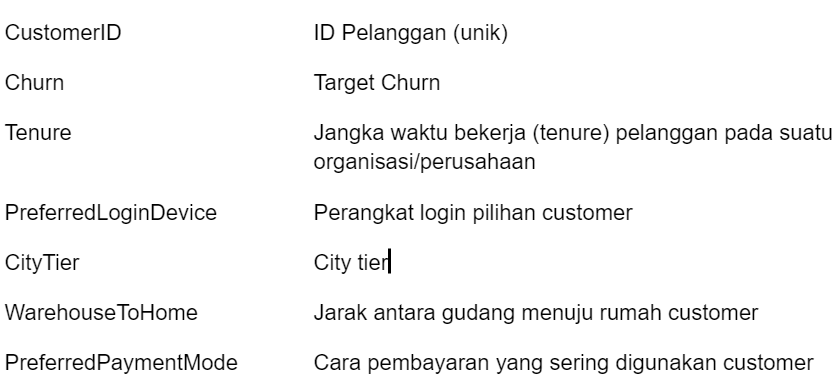

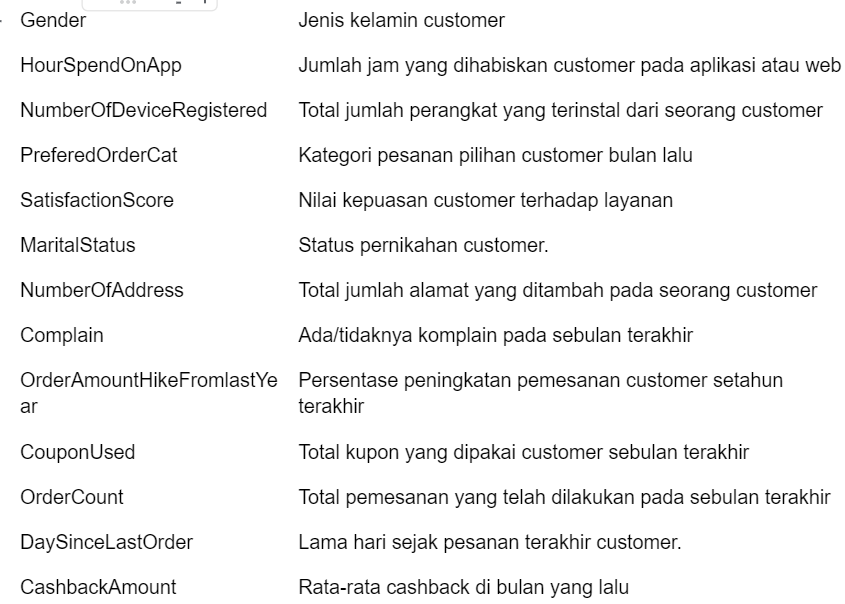

In [ ]:
print('Cek Prosentase Missing Value')
percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
dtypes=[df[col].dtype for col in df.columns]
missing_value_df = pd.DataFrame({'data_type':dtypes,
                                 'count_missing': df.isnull().sum(),
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df.head(8)

Cek Prosentase Missing Value


,data_type,count_missing,percent_missing
DaySinceLastOrder,float64,307,5.45
OrderAmountHikeFromlastYear,float64,265,4.71
Tenure,float64,264,4.69
OrderCount,float64,258,4.58
CouponUsed,float64,256,4.55
HourSpendOnApp,float64,255,4.53
WarehouseToHome,float64,251,4.46
CustomerID,int64,0,0.00


* Missing value tertinggi adalah 5.45% dari kolom `DaySinceLastOrder` yang merupakan lama hari sejak pesanan terakhir customer. Row missing value dari kolom ini akan dihapus karena akan mempengaruhi interpretasi terhadap waktu pesanan terakhir customer
* Kemudian, akan dilakukan analisis per kolom untuk fitur lainnya terkait imputasi

In [ ]:
# Drop "DaySinceLastOrder"
df = df.dropna(subset=['DaySinceLastOrder'])
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


* Kolom `WarehouseToHome` akan lebih logis apabila diimputasi dengan mean/median karena merupakan jarak dari gudang ke rumah customer
* Perlu dilihat jenis distribusinya terlebih dahulu

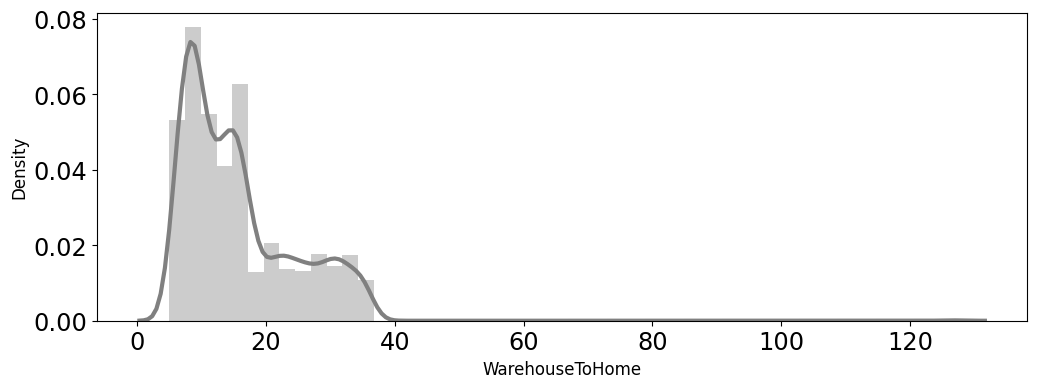

In [ ]:
sns.distplot(df['WarehouseToHome'], color='gray')
plt.show()

* Karena distribusinya skewed, maka akan diimputasi dengan median

In [ ]:
df['WarehouseToHome'] = df['WarehouseToHome'].fillna(df['WarehouseToHome'].median())
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


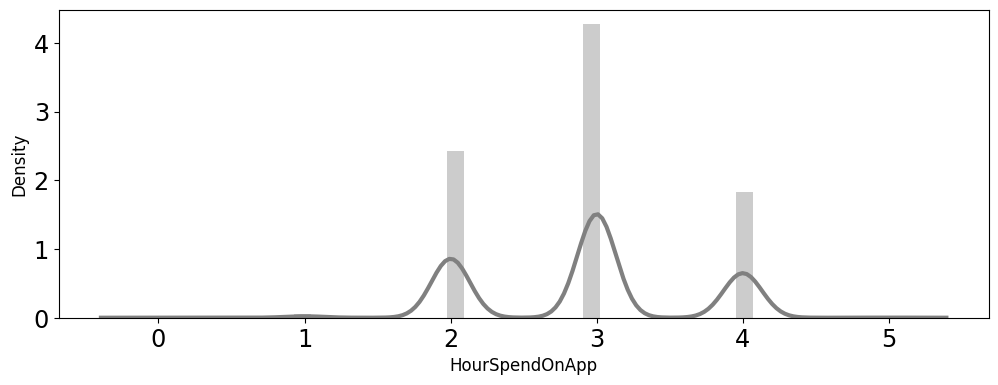

In [ ]:
sns.distplot(df['HourSpendOnApp'], color='gray')
plt.show()

In [ ]:
df['HourSpendOnApp'].value_counts()

3.0    2515
2.0    1431
4.0    1082
1.0      35
5.0       3
0.0       2
Name: HourSpendOnApp, dtype: int64

* Ternyata kolom `HourSpendOnApp` juga bisa memiliki 0, artinya pelanggan masih baru sehingga belum ada waktu untuk menjelajah app
* Dengan mengasumsikan bahwa missing value ini dari customer baru, maka kolom-kolom lainnya yakni `CouponUsed`, `OrderCount`, `OrderAmountHikeFromlastYear` dan `HourSpendOnApp` akan diimputasi dengan nilai 0, yang menunjukkan customer baru belum pernah menggunakan kupon, melakukan order dan spend waktu untuk menjelajah app

In [ ]:
# Imputasi kolom lainnya dengan "0"
missing = ['OrderAmountHikeFromlastYear','OrderCount','CouponUsed','HourSpendOnApp']
for col in missing:
    df[col] = df[col].fillna(0)
print("Imputation is success")

Imputation is success


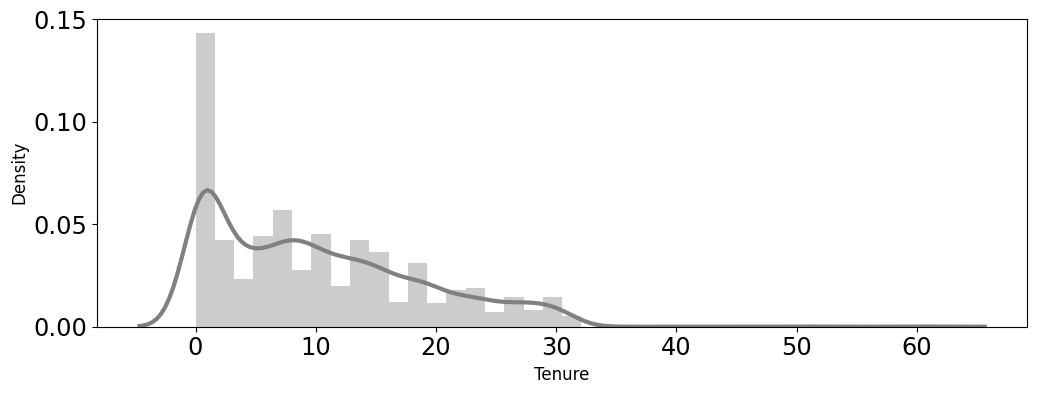

In [ ]:
sns.distplot(df['Tenure'], color='gray')
plt.show()

In [ ]:
df['Tenure'].value_counts()

1.0     658
0.0     505
8.0     245
9.0     225
7.0     217
5.0     190
4.0     189
10.0    187
3.0     184
11.0    182
13.0    175
14.0    168
6.0     168
12.0    162
2.0     160
15.0    153
16.0    145
19.0    133
18.0    120
17.0     98
20.0     96
23.0     85
22.0     73
21.0     72
24.0     67
28.0     66
27.0     66
30.0     64
25.0     57
26.0     52
29.0     52
31.0     41
50.0      1
60.0      1
51.0      1
61.0      1
Name: Tenure, dtype: int64

* Tenure terbanyak adalah 1 tahun masa kerja. 
* Maka, imputasi missing value akan dilakukan dengan mengasumsikan bahwa customer tersebut memiliki 1 tahun masa kerja sebagai customer baru

In [ ]:
df['Tenure'] = df['Tenure'].fillna(1)
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,1.0,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,1.0,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,0.0,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [ ]:
print('Cek Ulang Prosentase Missing Value')
percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
dtypes=[df[col].dtype for col in df.columns]
missing_value_df = pd.DataFrame({'data_type':dtypes,
                                 'count_missing': df.isnull().sum(),
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df

Cek Ulang Prosentase Missing Value


,data_type,count_missing,percent_missing
CustomerID,int64,0,0.0
Churn,int64,0,0.0
DaySinceLastOrder,float64,0,0.0
OrderCount,float64,0,0.0
CouponUsed,float64,0,0.0
OrderAmountHikeFromlastYear,float64,0,0.0
Complain,int64,0,0.0
NumberOfAddress,int64,0,0.0
MaritalStatus,object,0,0.0
SatisfactionScore,int64,0,0.0


* Sudah tidak ada missing value disini

In [ ]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,1.0,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,1.0,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,0.0,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


## Cek data Duplikasi

In [ ]:
# Cek duplikasi pada kolom "CustomerID"
boolean = df['CustomerID'].duplicated().any()
boolean

False

In [ ]:
df.duplicated().sum()

0

* Tidak ada duplikasi data dalam dataset ini

## Anomali pada kolom kategorikal

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5323 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5323 non-null   int64  
 1   Churn                        5323 non-null   int64  
 2   Tenure                       5323 non-null   float64
 3   PreferredLoginDevice         5323 non-null   object 
 4   CityTier                     5323 non-null   int64  
 5   WarehouseToHome              5323 non-null   float64
 6   PreferredPaymentMode         5323 non-null   object 
 7   Gender                       5323 non-null   object 
 8   HourSpendOnApp               5323 non-null   float64
 9   NumberOfDeviceRegistered     5323 non-null   int64  
 10  PreferedOrderCat             5323 non-null   object 
 11  SatisfactionScore            5323 non-null   int64  
 12  MaritalStatus                5323 non-null   object 
 13  NumberOfAddress   

In [ ]:
df['PreferredLoginDevice'].value_counts()

Mobile Phone    2553
Computer        1539
Phone           1231
Name: PreferredLoginDevice, dtype: int64

* Terdapat Mobile Phone dan Phone pada data ini, yang menjadi redundancy nilai pada kolom ini. Phone akan diubah menjadi Mobile Phone

In [ ]:
to_replace = ["Phone"]
df = df.replace(to_replace,'Mobile Phone')
print('Cek kembali')
df['PreferredLoginDevice'].value_counts()

Cek kembali


Mobile Phone    3784
Computer        1539
Name: PreferredLoginDevice, dtype: int64

In [ ]:
df['PreferredPaymentMode'].value_counts()

Debit Card          2189
Credit Card         1420
E wallet             559
UPI                  399
COD                  365
CC                   273
Cash on Delivery     118
Name: PreferredPaymentMode, dtype: int64

* Terdapat COD dan Cash on Delivery pada data ini, yang menjadi redundancy nilai pada kolom ini. COD akan diubah menjadi Cash On Delivery
* Hal yang sama juga terjadi pada CC dan Credit Card, sehingga CC akan diubah menjadi Credit Card

In [ ]:
to_replace = ["COD"]
df = df.replace(to_replace,'Cash on Delivery')

to_replace = ["CC"]
df = df.replace(to_replace,"Credit Card")

print('Cek kembali')
df['PreferredPaymentMode'].value_counts()

Cek kembali


Debit Card          2189
Credit Card         1693
E wallet             559
Cash on Delivery     483
UPI                  399
Name: PreferredPaymentMode, dtype: int64

In [ ]:
df['Gender'].value_counts()

Male      3199
Female    2124
Name: Gender, dtype: int64

In [ ]:
df['PreferedOrderCat'].value_counts()

Laptop & Accessory    1997
Mobile Phone          1271
Mobile                 809
Fashion                591
Grocery                391
Others                 264
Name: PreferedOrderCat, dtype: int64

* Mobile akan dijadikan sebagai Mobile Phone

In [ ]:
to_replace = ["Mobile"]
df = df.replace(to_replace,'Mobile Phone')
print('Cek kembali')
df['PreferedOrderCat'].value_counts()

Cek kembali


Mobile Phone          2080
Laptop & Accessory    1997
Fashion                591
Grocery                391
Others                 264
Name: PreferedOrderCat, dtype: int64

In [ ]:
df['MaritalStatus'].value_counts()

Married     2811
Single      1709
Divorced     803
Name: MaritalStatus, dtype: int64

## Pembagian Numerikal-Kategorikal

In [ ]:
num = list(df.select_dtypes(exclude='object').columns)
cat = list(df.select_dtypes(exclude=['int64','float64']).columns)
print(num)
print(cat)

['CustomerID', 'Churn', 'Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']


## Handling Outlier

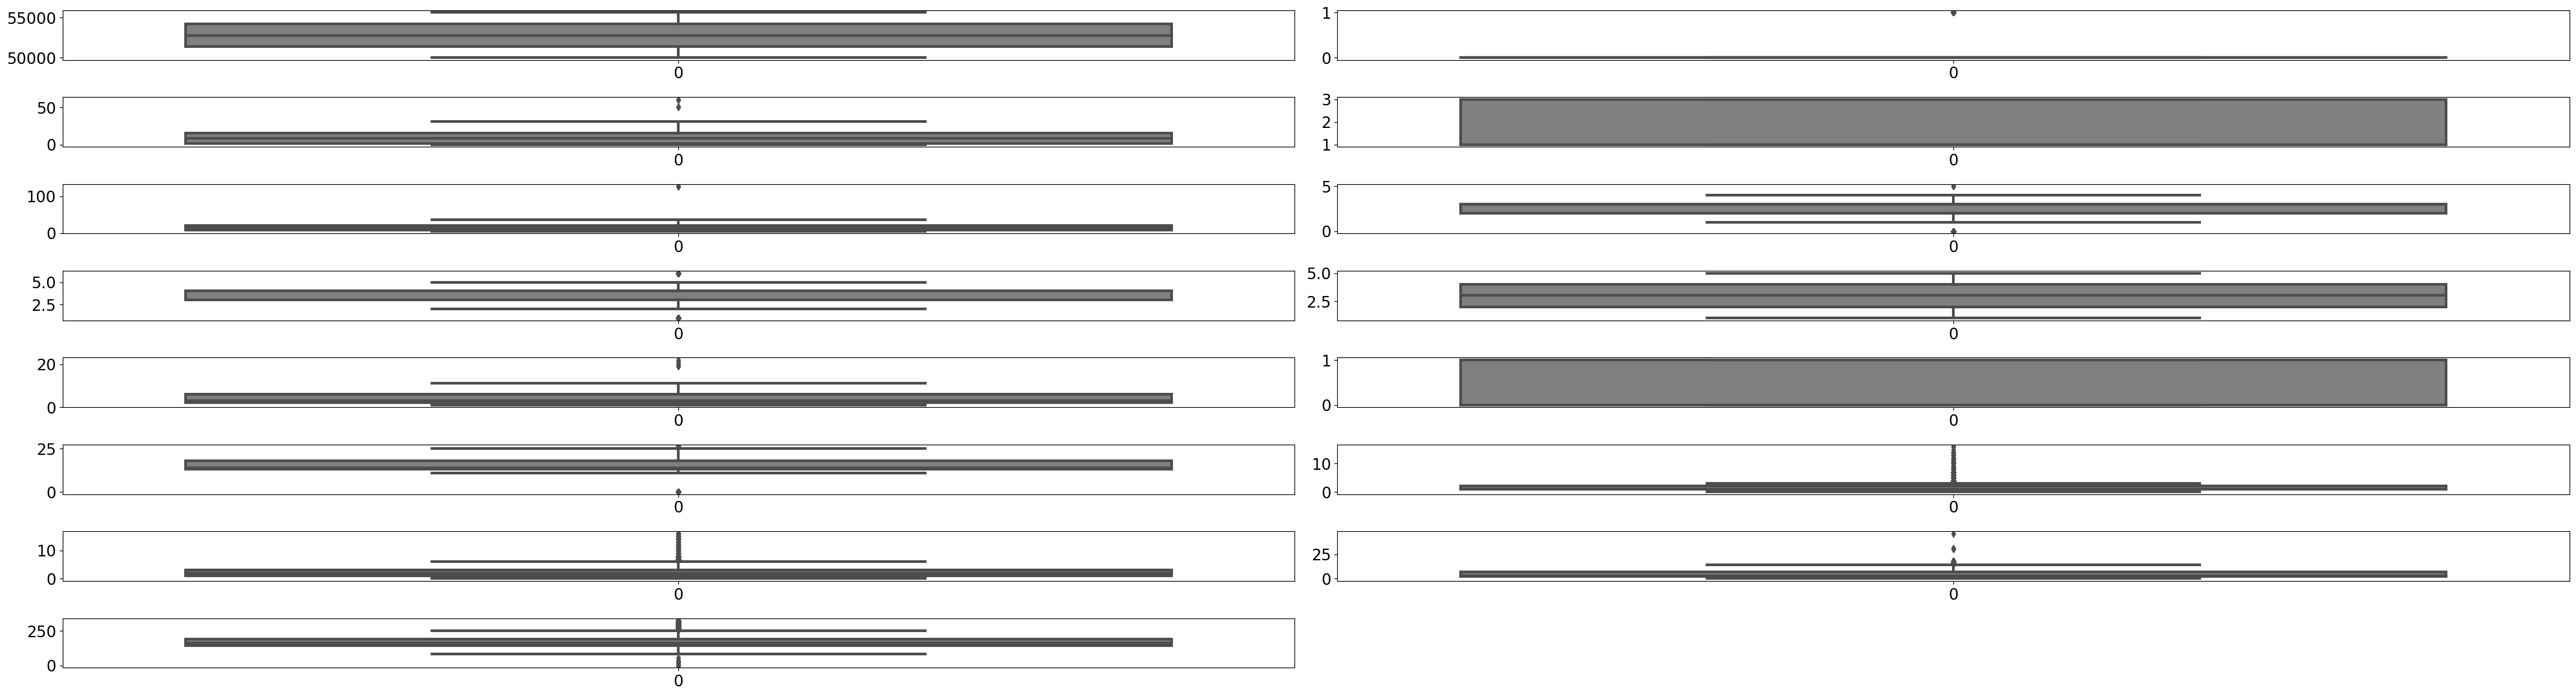

In [ ]:
plt.figure(figsize=(40, 20))
for i in range(0, len(num)):
    plt.subplot(len(num), 2, i+1)
    sns.boxplot(df[num[i]], color='gray', orient='v')
    plt.tight_layout()

* Hampir setiap kolom numerik memiliki outlier
* Beberapa kolom akan di-exclude dari outlier removal:
  1. `CustomerID`
  2. `Churn`
  3. `Complain`
  4. `CityTier`
  5. `SatisfactionScore`
* Kolom lainnya akan dilakukan outlier removal dengan Z Scores

In [ ]:
# Digunakan metode Z Scores agar tidak banyak kehilangan data
exclude = ['CustomerID','Churn','Complain','CityTier','SatisfactionScore']
outlier = list(set(num)-set(exclude))

print(f'Sebelum handling outlier: {len(df)}')

for out in outlier:
  filtered_entries = np.array([True] * len(df))
  zscore = abs(st.zscore(df[out]))
  filtered_entries = (zscore < 3) & filtered_entries
  # Simpan data tanpa outlier dengan nama "df"   
  df = df[filtered_entries]

print(f'Sesudah handling outlier: {len(df)}')

Sebelum handling outlier: 5323
Sesudah handling outlier: 4728


In [ ]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,1.0,Mobile Phone,1,8.0,UPI,Male,3.0,4,Mobile Phone,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,1.0,Mobile Phone,1,30.0,Debit Card,Male,2.0,4,Mobile Phone,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Mobile Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Mobile Phone,1,12.0,Credit Card,Male,0.0,3,Mobile Phone,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4728 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   4728 non-null   int64  
 1   Churn                        4728 non-null   int64  
 2   Tenure                       4728 non-null   float64
 3   PreferredLoginDevice         4728 non-null   object 
 4   CityTier                     4728 non-null   int64  
 5   WarehouseToHome              4728 non-null   float64
 6   PreferredPaymentMode         4728 non-null   object 
 7   Gender                       4728 non-null   object 
 8   HourSpendOnApp               4728 non-null   float64
 9   NumberOfDeviceRegistered     4728 non-null   int64  
 10  PreferedOrderCat             4728 non-null   object 
 11  SatisfactionScore            4728 non-null   int64  
 12  MaritalStatus                4728 non-null   object 
 13  NumberOfAddress   

## Analisis Bivariat

Disini kita akan melihat bagaimana korelasi antar 2 kolom/variabel pada dataset. Semakin mendekati 1 berarti korelasinya positif. Sebaliknya, semakin mendekati -1 maka korelasinya negatif. Jika berada di sekitaran 0 maka kedua variabel tidak berkorelasi

In [ ]:
# #menambahkan satu variabel baru untuk melihat rata-rata cashback per order
# df['avg_cashbk_per_order'] = df['CashbackAmount'] / df['OrderCount']
# df.head()

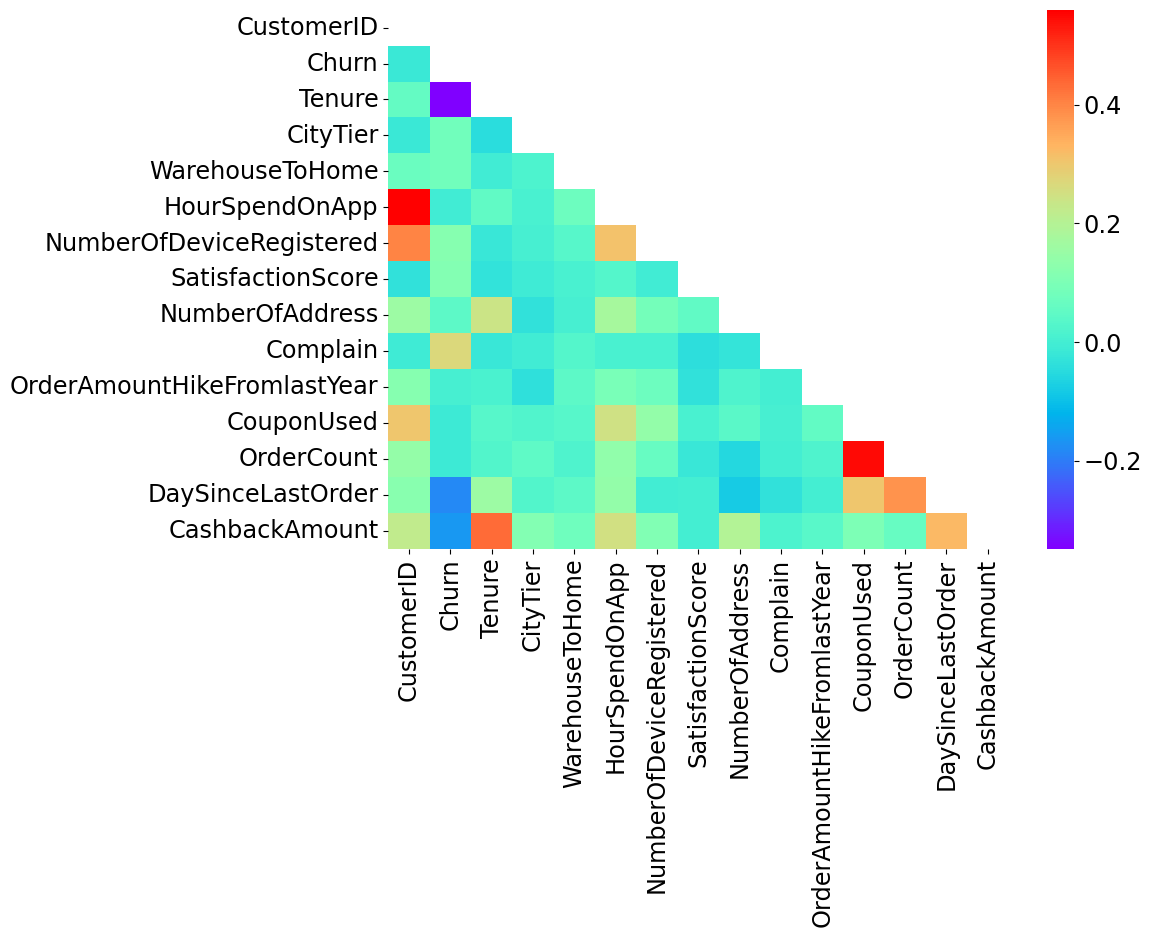

In [ ]:
mask=np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots( figsize=(10, 7))
sns.heatmap(df.corr(), mask=mask, cmap='rainbow');

Dari hasil diatas, dapat terlihat bahwa beberapa variabel memiliki korelasi posisif yang cukup kuat, yaitu:

1. Tenure dan CashbackAmount
2. CouponUsed dan OrderCount

beberapa variabel yang memiliki korelasi positif lemah diantaranya:

1. OrderCount dan DaySinceLastOrder
2. HourSpendOnApp dan NumberOfDeviceRegistered
3. DaySinceLastOrder dan CashbackAmount
4. CouponUsed dan DaySinceLastOrder
5. OrderCount dan CashbackAmount

beberapa variabel yang memiliki korelasi negatif lemah:
1. Tenure dan Churn

sementara sisanya tidak begitu berkorelasi. 

Untuk lebih jelasnya, perhatikan output dibawah:

In [ ]:
indeks = df.corr().index
nums = len(indeks)
ncorr = 0.3
list_corr = []

for i in range(1,nums):
  for j in range(i+1,nums):
    corr_val = round(df.corr().iloc[i,j],2)
    if abs(corr_val) >= ncorr:
      list_corr.append([indeks[i], indeks[j], corr_val])

list_corr.sort(reverse = True, key = lambda list_corr: list_corr[2])

for i in list_corr:
  print(f'{i[0]} dan {i[1]} : {i[2]}')

CouponUsed dan OrderCount : 0.55
Tenure dan CashbackAmount : 0.43
OrderCount dan DaySinceLastOrder : 0.38
DaySinceLastOrder dan CashbackAmount : 0.32
HourSpendOnApp dan NumberOfDeviceRegistered : 0.31
CouponUsed dan DaySinceLastOrder : 0.3
Churn dan Tenure : -0.35


Dengan menggunakan korelasi > 0.5 sebagai standar feature selection, maka fitur yang dihapus adalah:
* CouponUsed
* Tenure

In [ ]:
df.drop(columns=['Tenure', 'CouponUsed'], inplace=True)

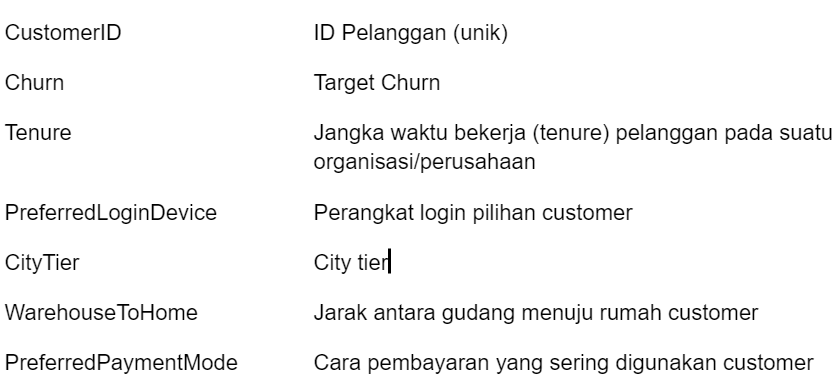

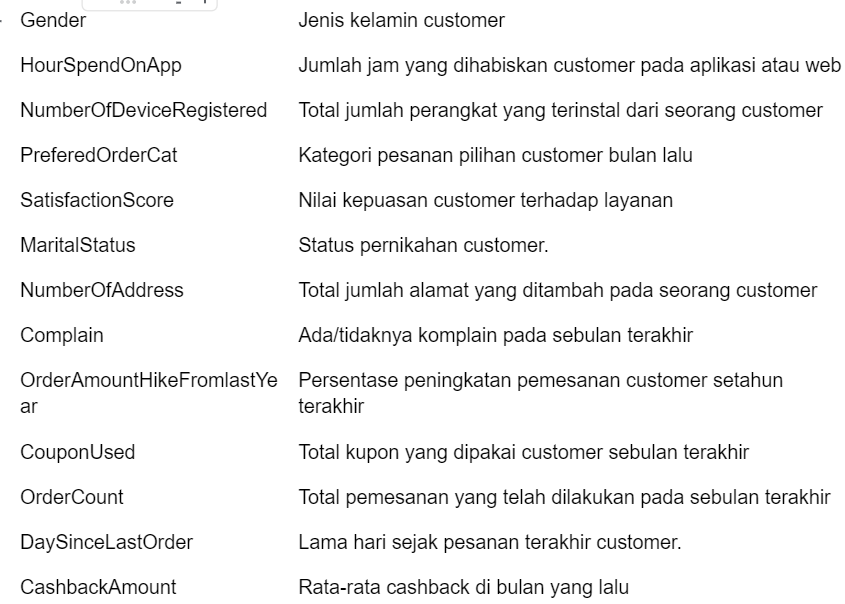

In [ ]:
# Saving cleaned data to .csv
df.to_csv('df.csv', index=False)

# Exploratory Data Analysis

##Pengecekan kondisi data setelah Data Cleansing

In [ ]:
df.head()

,CustomerID,Churn,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,5.0,159.93
1,50002,1,Mobile Phone,1,8.0,UPI,Male,3.0,4,Mobile Phone,3,Single,7,1,15.0,1.0,0.0,120.90
2,50003,1,Mobile Phone,1,30.0,Debit Card,Male,2.0,4,Mobile Phone,3,Single,6,1,14.0,1.0,3.0,120.28
3,50004,1,Mobile Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,1.0,3.0,134.07
4,50005,1,Mobile Phone,1,12.0,Credit Card,Male,0.0,3,Mobile Phone,5,Single,3,0,11.0,1.0,3.0,129.60


In [ ]:
df.shape

(4728, 18)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4728 entries, 0 to 5629
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   4728 non-null   int64  
 1   Churn                        4728 non-null   int64  
 2   PreferredLoginDevice         4728 non-null   object 
 3   CityTier                     4728 non-null   int64  
 4   WarehouseToHome              4728 non-null   float64
 5   PreferredPaymentMode         4728 non-null   object 
 6   Gender                       4728 non-null   object 
 7   HourSpendOnApp               4728 non-null   float64
 8   NumberOfDeviceRegistered     4728 non-null   int64  
 9   PreferedOrderCat             4728 non-null   object 
 10  SatisfactionScore            4728 non-null   int64  
 11  MaritalStatus                4728 non-null   object 
 12  NumberOfAddress              4728 non-null   int64  
 13  Complain          

## Splitting Data

In [ ]:
num = list(df.select_dtypes(exclude='object').columns)
cat = list(df.select_dtypes(exclude=['int64','float64']).columns)

In [ ]:
print(f'variabel numerikal = {num}')
print(f'Jumlah variabel numerikal = {len(num)}\n')
print(f'variabel kategorikal = {cat}')
print(f'Jumlah variabel kategorikal = {len(cat)}')

variabel numerikal = ['CustomerID', 'Churn', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
Jumlah variabel numerikal = 13

variabel kategorikal = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']
Jumlah variabel kategorikal = 5


In [ ]:
for i in num:
  print(f'{df.value_counts(i)}')
  print(f'Data unik : {df[i].nunique()}\n')

CustomerID
50001    1
53623    1
53651    1
53650    1
53648    1
        ..
51781    1
51780    1
51779    1
51778    1
55630    1
Length: 4728, dtype: int64
Data unik : 4728

Churn
0    3886
1     842
dtype: int64
Data unik : 2

CityTier
1    3094
3    1429
2     205
dtype: int64
Data unik : 3

WarehouseToHome
14.0    494
9.0     432
8.0     380
7.0     313
16.0    283
6.0     259
15.0    248
10.0    211
13.0    205
12.0    185
11.0    184
17.0    178
31.0     90
23.0     85
22.0     84
30.0     83
26.0     83
24.0     76
18.0     76
32.0     76
35.0     75
25.0     74
27.0     72
29.0     69
21.0     67
19.0     64
28.0     63
20.0     62
34.0     56
33.0     54
36.0     41
5.0       6
dtype: int64
Data unik : 32

HourSpendOnApp
3.0    2210
2.0    1286
4.0     945
0.0     251
1.0      34
5.0       2
dtype: int64
Data unik : 6

NumberOfDeviceRegistered
4    1919
3    1517
5     706
2     240
1     222
6     124
dtype: int64
Data unik : 6

SatisfactionScore
3    1432
1     986
5     9

## Descriptive Statistics

In [ ]:
#descriptive statistic data numerikal

df[num].describe()

,CustomerID,Churn,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,OrderCount,DaySinceLastOrder,CashbackAmount
count,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000,4728.000000
mean,52736.045262,0.178088,1.647843,15.648477,2.755076,3.638536,3.057530,4.112944,0.288283,15.687817,2.287014,4.121616,164.226593
std,1621.628676,0.382627,0.912580,8.082814,0.959336,1.034548,1.379253,2.528354,0.453011,3.645295,1.980203,3.214596,34.682111
min,50001.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,0.000000,56.000000
25%,51333.750000,0.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,2.000000,142.720000
50%,52658.500000,0.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,2.000000,3.000000,155.650000
75%,54137.750000,0.000000,3.000000,20.000000,3.000000,4.000000,4.000000,5.000000,1.000000,18.000000,2.000000,7.000000,178.832500
max,55630.000000,1.000000,3.000000,36.000000,5.000000,6.000000,5.000000,11.000000,1.000000,26.000000,11.000000,14.000000,282.130000


In [ ]:
#descriptive statistic data kategorikal

df[cat].describe()

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,4728,4728,4728,4728,4728
unique,2,5,2,5,3
top,Mobile Phone,Debit Card,Male,Mobile Phone,Married
freq,3332,1943,2847,2038,2470


Dari data diatas diketahui beberapa hal berikut:

- Kebanyakan customer login dengan menggunakan Mobile Phone, yaitu sebanyak 3358 orang.
- Kebanyakan customer membayar dengan kartu kredit, yaitu sebanyak 1966 orang.
- Kebanyakan customer membeli barang dengan jenis/kategori Mobile Phone, yaitu sekitar 2051 order.
- Kebanyakan customer berjenis kelamin laki-laki, yaitu sekitar 2860 orang.
- Kebanyakan customer sudah menikah, yaitu sekitar 2489 orang.

## Analisis Distribusi Data

### Histogram data numerikal

Tidak semua data numerikal akan di cek distribusinya dalam bentuk histogram. Yang akan di cek disini diantaranya:

- WarehouseToHome
- OrderAmountHikeFromlastYear
- DaySinceLastOrder
- CashbackAmount

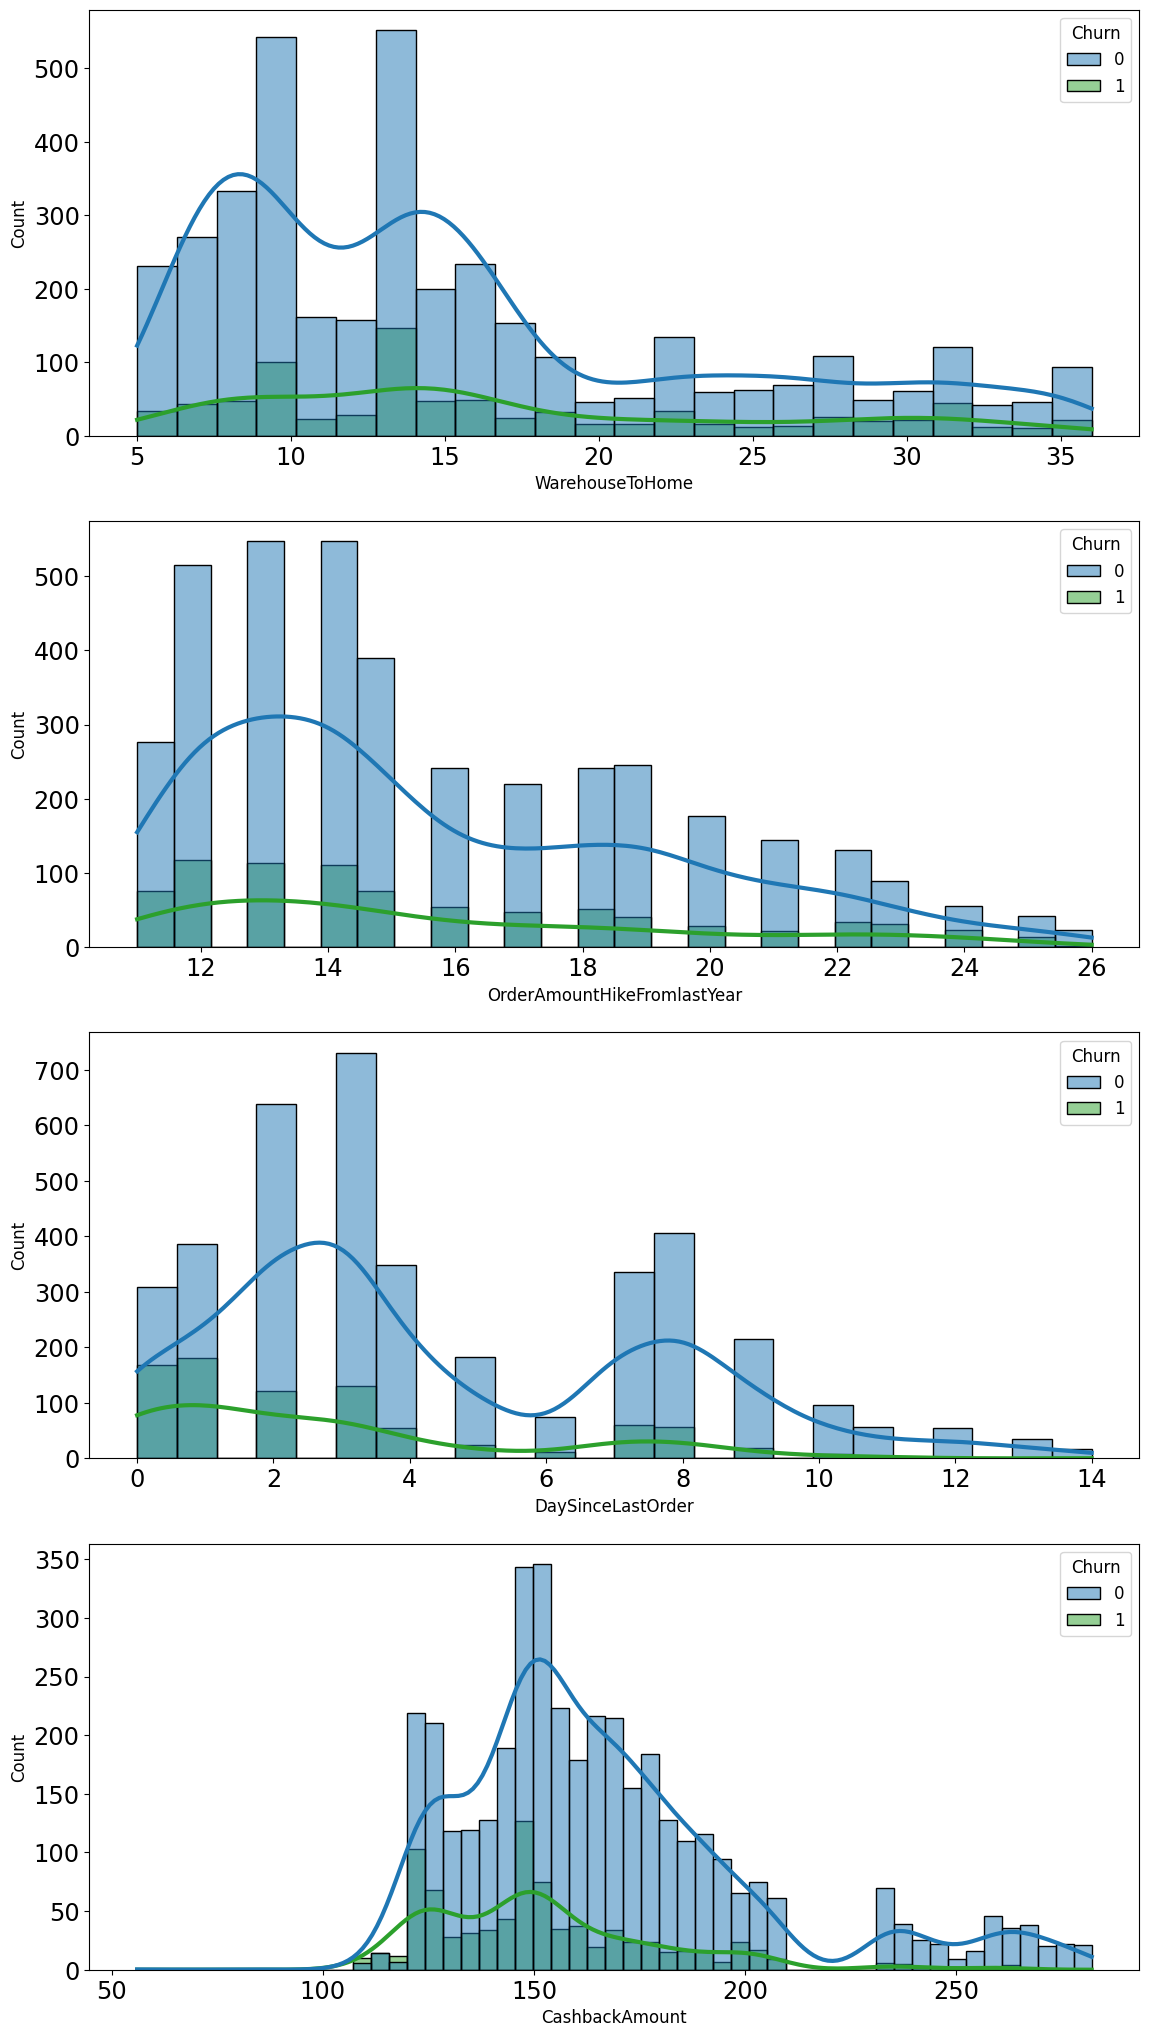

In [ ]:
data1 = ['WarehouseToHome', 'OrderAmountHikeFromlastYear', 
        'DaySinceLastOrder', 'CashbackAmount']

for i in range(len(data1)):
  plt.subplot(len(data1),1,i+1)
  sns.histplot(data=df, x=data1[i], hue='Churn', palette=['tab:blue', 'tab:green'], kde=True)
  plt.subplots_adjust(bottom = 0.1, right = 1, top = 5);

In [ ]:
#menghitung skewness dan kurtosis data churn

for i in data1:
  print(df[df['Churn']==1][i].agg(['skew', 'kurtosis']).transpose())
  print('\n')

skew        0.688449
kurtosis   -0.648764
Name: WarehouseToHome, dtype: float64


skew        0.793607
kurtosis   -0.400615
Name: OrderAmountHikeFromlastYear, dtype: float64


skew        1.034421
kurtosis    0.150264
Name: DaySinceLastOrder, dtype: float64


skew        1.139035
kurtosis    1.697880
Name: CashbackAmount, dtype: float64




In [ ]:
#menghitung skewness dan kurtosis data non-churn

for i in data1:
  print(df[df['Churn']==0][i].agg(['skew', 'kurtosis']).transpose())
  print('\n')

skew        0.964062
kurtosis   -0.061187
Name: WarehouseToHome, dtype: float64


skew        0.771928
kurtosis   -0.276133
Name: OrderAmountHikeFromlastYear, dtype: float64


skew        0.674387
kurtosis   -0.439358
Name: DaySinceLastOrder, dtype: float64


skew        1.235339
kurtosis    1.410235
Name: CashbackAmount, dtype: float64




Secara keseluruhan, keempat variabel diatas (WarehouseToHome, OrderAmountHikeFromlastYear, DaySinceLastOrder, CashbackAmount) **tidak berdistribusi normal**. Baik itu untuk customer yang churn maupun tidak churn.

### Distribusi data numerikal lainnya terhadap variabel target

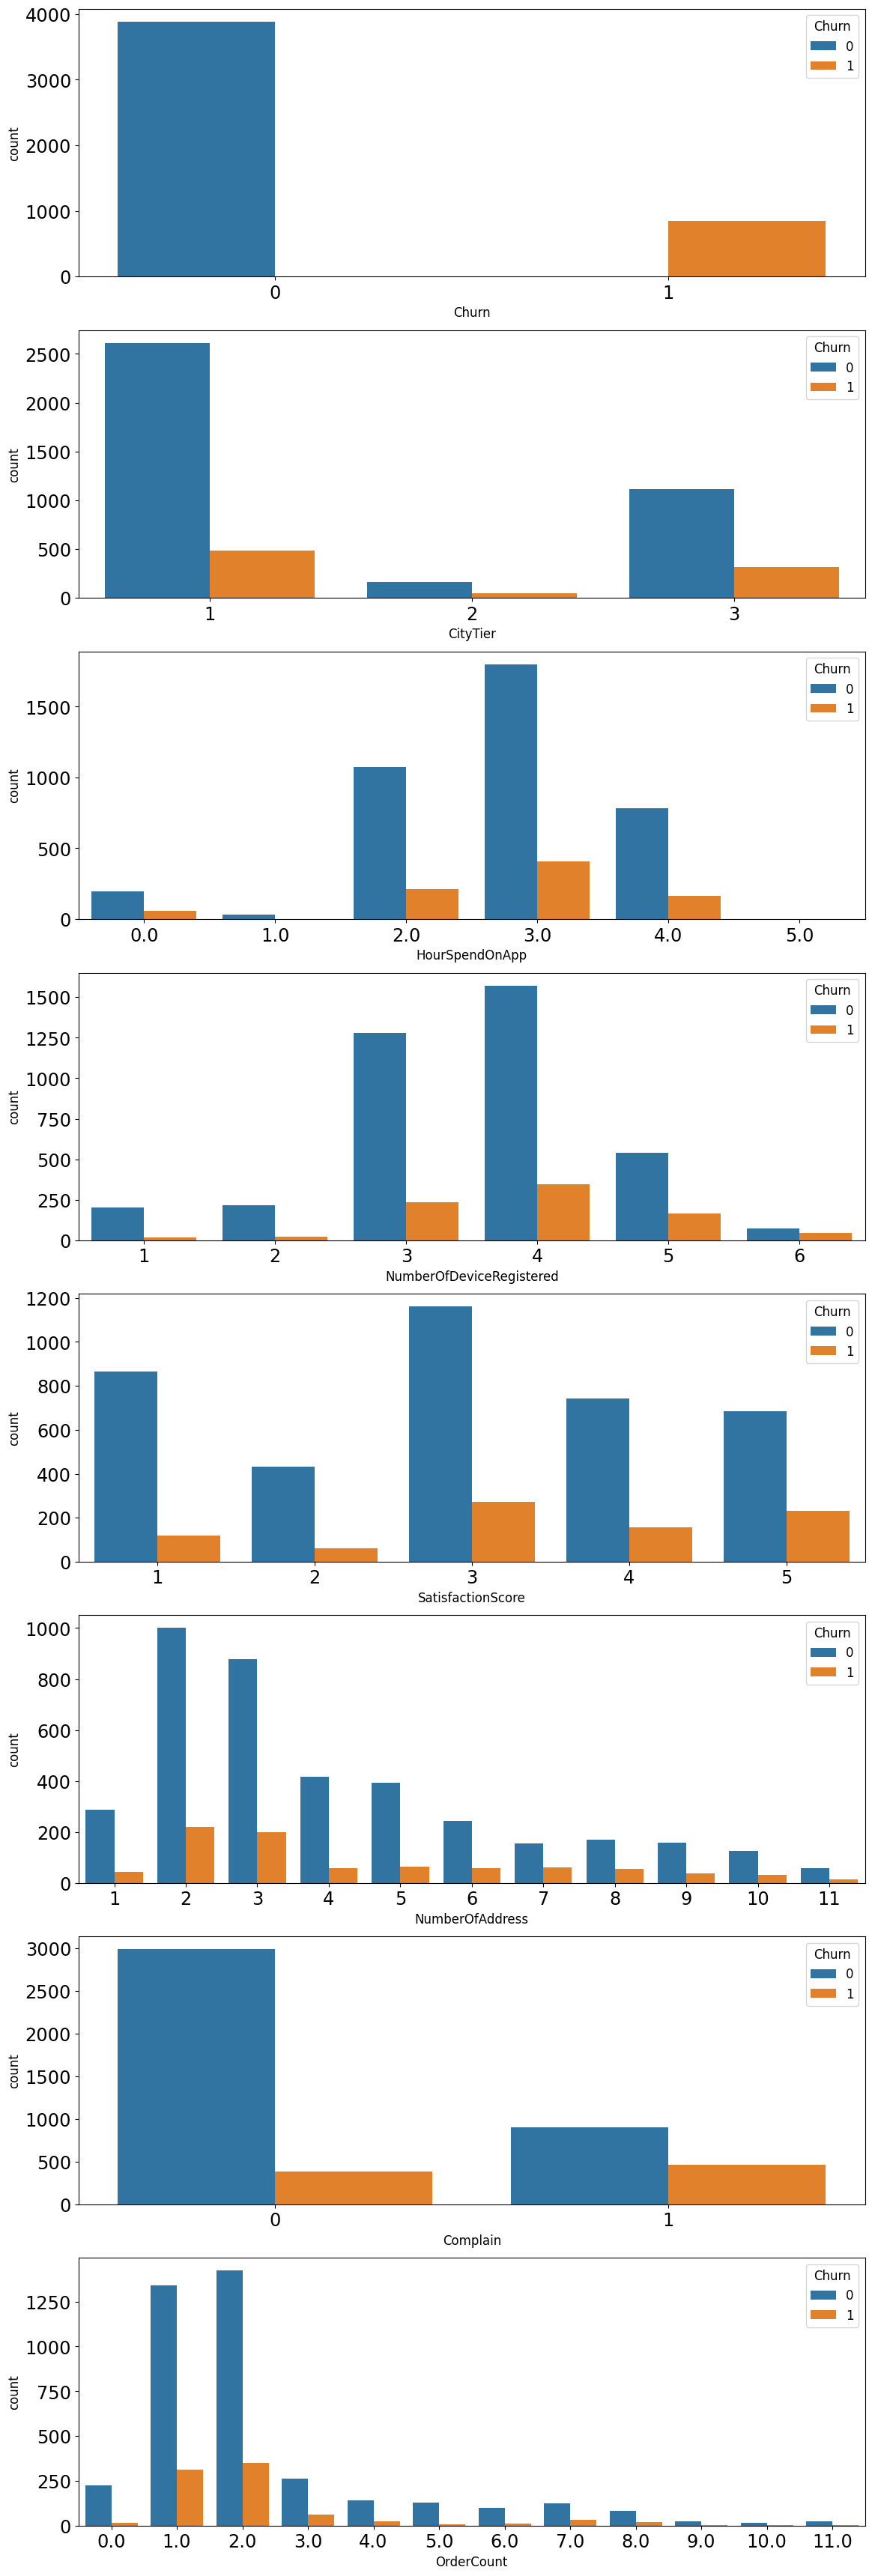

In [ ]:
data2 = [i for i in num if i not in data1+['CustomerID']]

for i in range(len(data2)):
  plt.subplot(len(data2),1,i+1)
  sns.countplot(data=df, x=data2[i], hue='Churn')
  plt.subplots_adjust(bottom = 0.1, right = 1, top = 8.5);

* Terdapat imbalanced class sehingga perlu dilakukan oversampling pada class "Churn"

### Cek distribusi data kategorikal terhadap variabel target

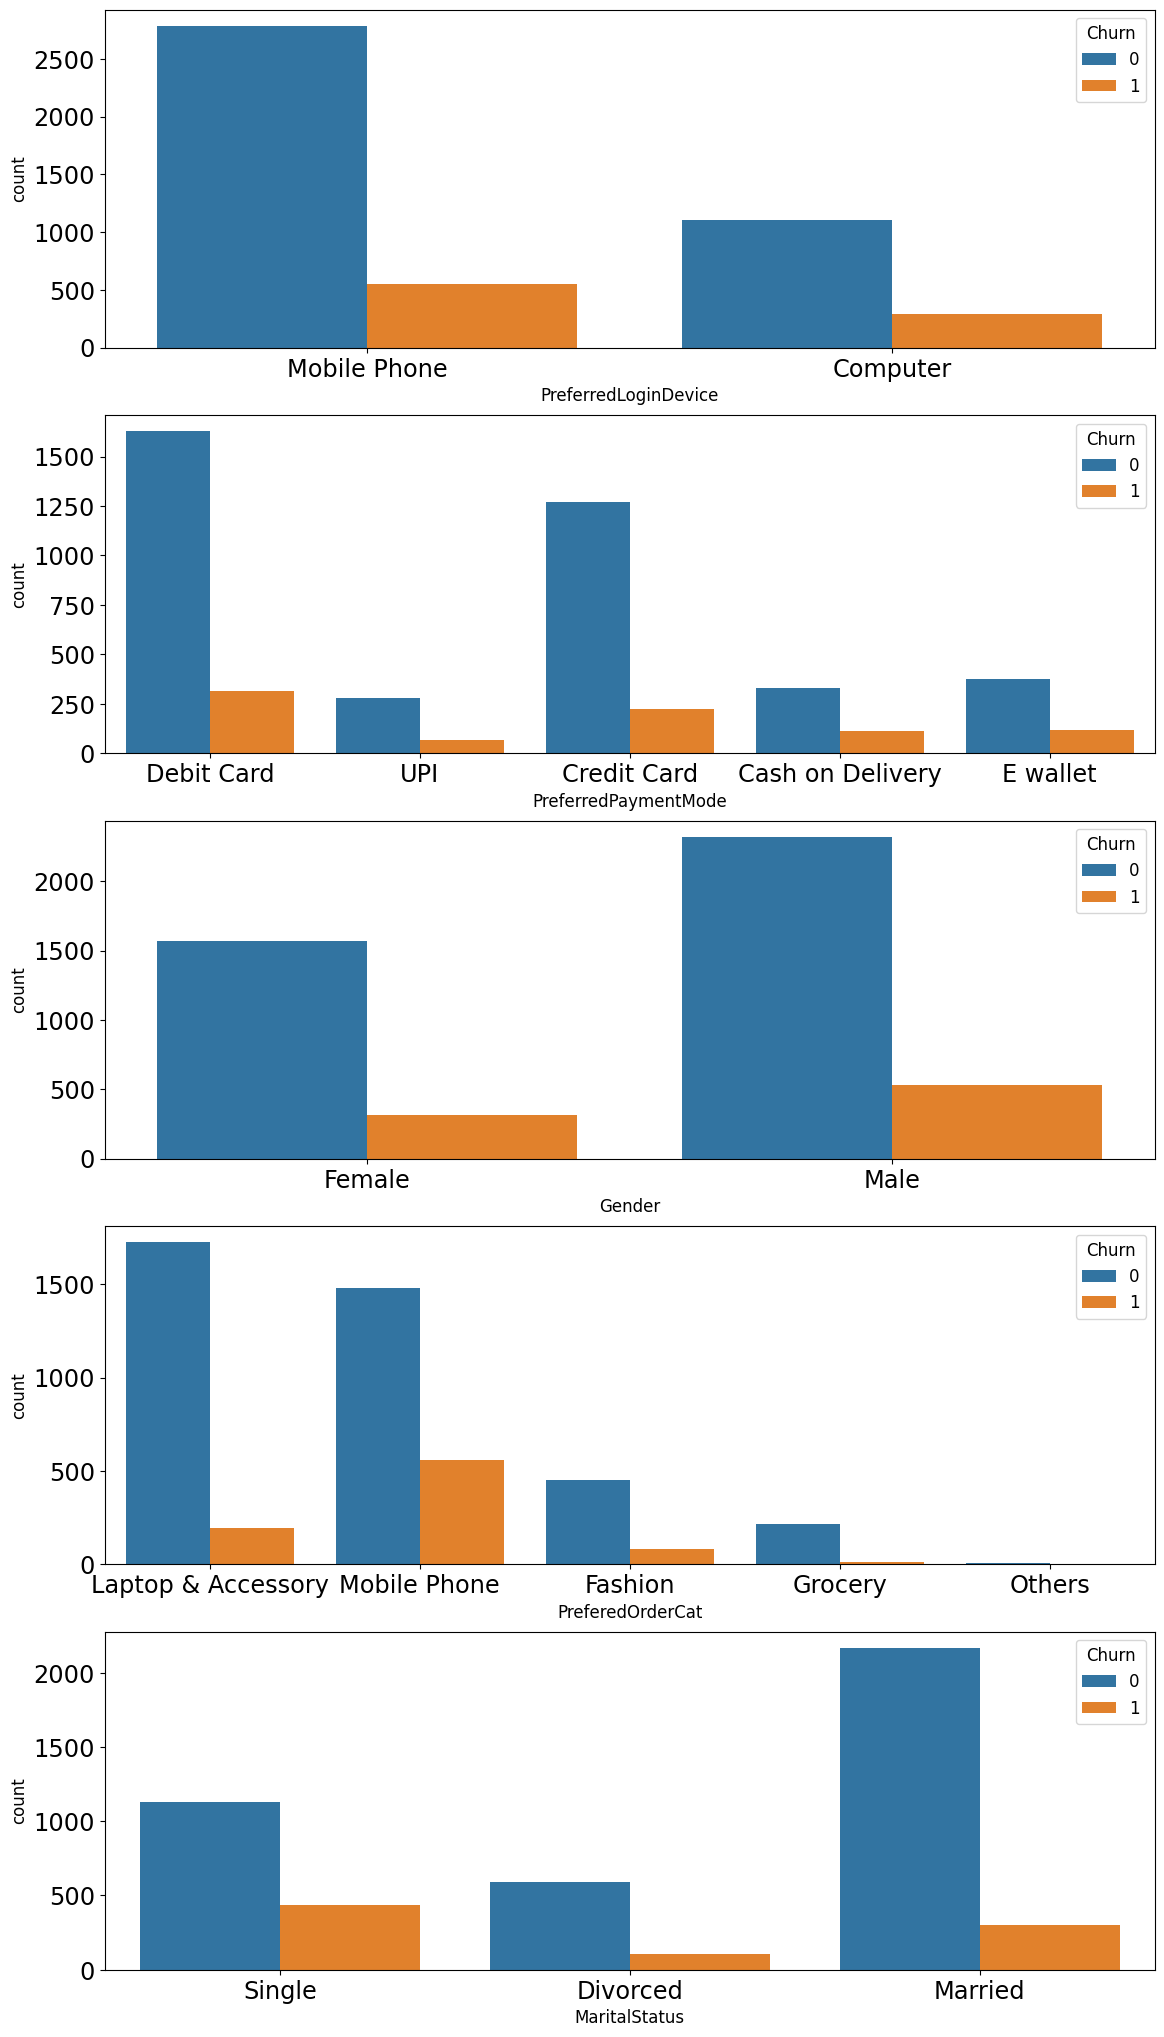

In [ ]:
for i in range(len(cat)):
  plt.subplot(5,1,i+1)
  sns.countplot(data=df, x=cat[i], hue = 'Churn')
  plt.subplots_adjust(bottom = 0.1, right = 1, top = 5);

* Pengguna yang membayar dengan Credit Card merupakan pengguna terbanyak yang churn
* Selain itu, order ponsel (Mobile Phone) menduduki posisi teratas dari banyaknya pengguna yang churn

# Insights

In [ ]:
# Load data yang sudah bersih
# LANGSUNG RUNNING SINI AJA YAAA
# Load dataset (sudah saya koneksikan dengan Github, jadi tinggal run aja okay :D )
!git clone https://github.com/yohset95/DatasetFP_FSB

Cloning into 'DatasetFP_FSB'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 2), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (10/10), 607.85 KiB | 1.72 MiB/s, done.


In [ ]:
df = pd.read_csv('/content/DatasetFP_FSB/df.csv') 
df.head()

,CustomerID,Churn,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,5.0,159.93
1,50002,1,Mobile Phone,1,8.0,UPI,Male,3.0,4,Mobile Phone,3,Single,7,1,15.0,1.0,0.0,120.90
2,50003,1,Mobile Phone,1,30.0,Debit Card,Male,2.0,4,Mobile Phone,3,Single,6,1,14.0,1.0,3.0,120.28
3,50004,1,Mobile Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,1.0,3.0,134.07
4,50005,1,Mobile Phone,1,12.0,Credit Card,Male,0.0,3,Mobile Phone,5,Single,3,0,11.0,1.0,3.0,129.60


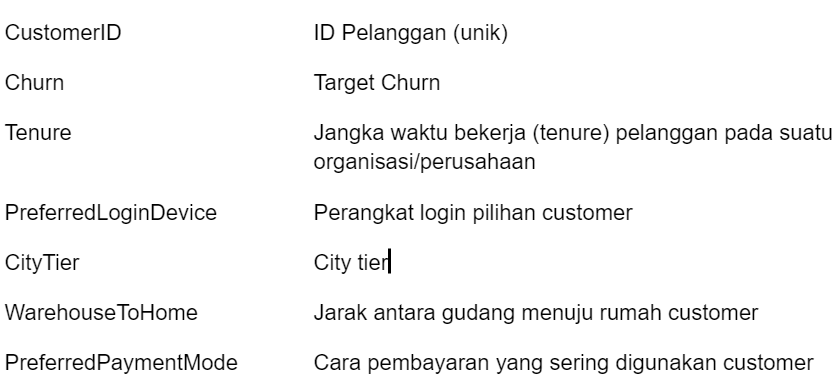

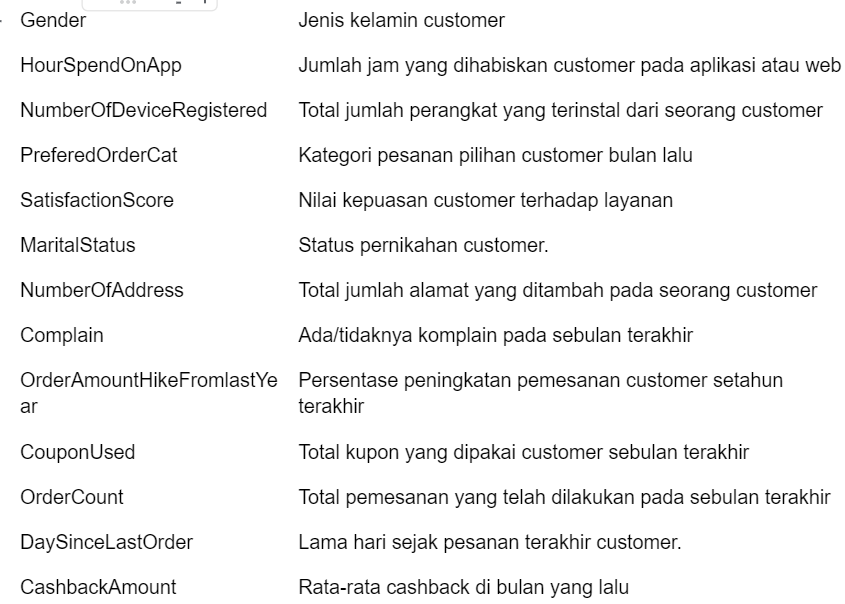

## Apakah customer yang churn terbanyak karena pelayanan e-Commerce?

* Cek visualisasi komplain terhadap churn

In [ ]:
crosstable = pd.crosstab(df['Complain'],df['Churn'])
crosstable

Churn,0,1
Complain,,
0,2996,388
1,909,465


In [ ]:
df_copy = df.copy()
df_copy['Churn'] = df_copy['Churn'].replace([1, 0], ['Churn', 'Not Churn'])
df_copy['Complain'] = df_copy['Complain'].replace([1, 0], ['Complain', 'Not Complain'])

churn_1_complain_1 = len(df_copy[(df_copy['Churn'] == 'Churn') & (df_copy['Complain'] == 'Complain')])
churn_0_complain_0 = len(df_copy[(df_copy['Churn'] == 'Not Churn') & (df_copy['Complain'] == 'Not Complain')])
churn_0_complain_1 = len(df_copy[(df_copy['Churn'] == 'Not Churn') & (df_copy['Complain'] == 'Complain')])
churn_1_complain_0 = len(df_copy[(df_copy['Churn'] == 'Churn') & (df_copy['Complain'] == 'Not Complain')])

churn_1_complain_1

465

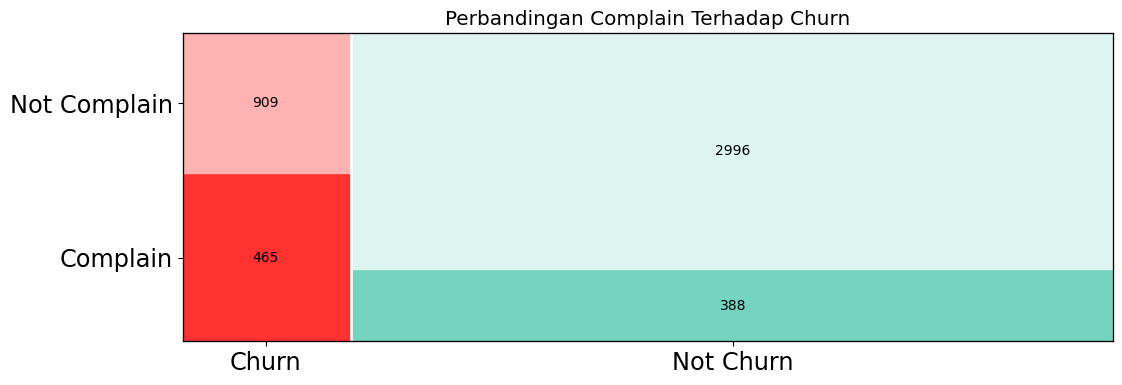

In [ ]:
cols = {('Churn', 'Complain'):'#FF3131',('Not Churn', 'Complain'):'#74d4c0',
        ('Churn','Not Complain' ):'#ffb2b2', ('Not Churn', 'Not Complain'):'#def4f0'}

labelizer=lambda k:{('Churn','Complain'):churn_1_complain_1,('Not Churn','Not Complain'):churn_0_complain_0,('Churn','Not Complain'):churn_0_complain_1,('Not Churn','Complain'):churn_1_complain_0}[k]
mosaic(df_copy,['Churn','Complain'],labelizer=labelizer,properties=lambda key: {'color': cols[key]}, title='Perbandingan Complain Terhadap Churn')
plt.show()

* Sebanyak 465 dari 1374 customer yang churn melakukan komplain (33%)

## Bagaimana karakteristik customer kita?

* H0 : banyaknya waktu yang dihabiskan oleh customer yang churn sama dengan yang tidak churn
* H1 : banyaknya waktu yang dihabiskan oleh customer yang churn tidak sama dengan yang tidak churn

In [ ]:
ttest = st.ttest_ind(a = df[df['Churn']==1]['HourSpendOnApp'], b=df[df['Churn']==0]['HourSpendOnApp'])
p_value = ttest.pvalue
print('P-Value :',p_value)
if p_value < 0.05:
    print('H0 ditolak')
else:
    print('H0 diterima')

P-Value : 0.7144804383801883
H0 diterima


* Klaim ditolak
* Banyaknya waktu yang dihabiskan oleh customer yang churn sama dengan yang tidak churn

Akan dicek dulu apakah peningkatan pemesanan dari customer pada setahun terakhir memiliki pengaruh terhadap customer yang churn
* H0: rata-rata dari peningkatan pemesanan dari customer yang churn sama dengan customer yang tidak churn
* H1: rata-rata dari peningkatan pemesanan dari customer yang churn tidak sama dengan customer yang tidak churn (Klaim)

In [ ]:
ttest = st.ttest_ind(a = df[df['Churn']==1]['OrderAmountHikeFromlastYear'], b=df[df['Churn']==0]['OrderAmountHikeFromlastYear'])
p_value = ttest.pvalue
print('P-Value :',p_value)
if p_value < 0.05:
    print('H0 ditolak')
else:
    print('H0 diterima')

P-Value : 0.9281298041168569
H0 diterima


* Klaim ditolak
* Customer yang churn memiliki peningkatan pemesanan sama dengan customer yang tidak churn pada setahun terakhir

Selanjutnya, akan diuji mengenai banyaknya pemesanan pada sebulan terakhir antara customer yang churn dan tidak churn. Apakah yang churn lebih rendah?
* H0: rata-rata banyaknya pemesanan sebulan terakhir dari customer yang churn sama dengan yang tidak churn
* H1: rata-rata banyaknya pemesanan sebulan terakhir dari customer yang churn tidak sama dengan dari yang tidak churn (Klaim)

In [ ]:
ttest = st.ttest_ind(a = df[df['Churn']==1]['OrderCount'], b=df[df['Churn']==0]['OrderCount'])
p_value = ttest.pvalue
print('P-Value :',p_value)
if p_value < 0.05:
    print('H0 ditolak')
else:
    print('H0 diterima')

P-Value : 0.8801374633680463
H0 diterima


* Klaim ditolak
* Customer yang churn masih memiliki banyaknya pemesanan sebulan terakhir yang sama dengan yang tidak churn

Terakhir akan diuji apakah lama hari sejak pesanan terakhir dari customer yang churn lebih kecil daripada yang tidak churn
* H0: Lama hari sejak pesanan terakhir dari customer yang churn lebih besar atau sama dengan customer yang tidak churn 
* H1: Lama hari sejak pesanan terakhir dari customer yang churn lebih kecil daripada yang tidak churn (Klaim)

In [ ]:
ttest = st.ttest_ind(a = df[df['Churn']==1]['DaySinceLastOrder'], b=df[df['Churn']==0]['DaySinceLastOrder'], alternative='less')
p_value = ttest.pvalue
print('P-Value :',p_value)
if p_value < 0.05:
    print('H0 ditolak')
else:
    print('H0 diterima')

P-Value : 2.103336038236089e-34
H0 ditolak


* Klaim diterima
* Customer yang churn memiliki lama hari sejak pesanan terakhir yang lebih kecil atau sama dengan dari yang tidak churn

## Mengapa penjualan barang elektronika seperti mobile phone, laptop beserta aksesorisnya memiliki banyak customer yang churn?

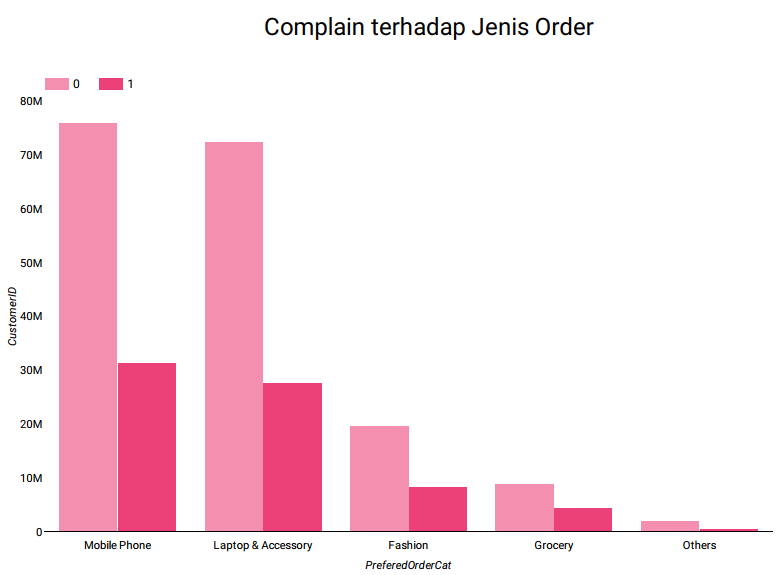

* Terlihat bahwa mobile phone memiliki tingkat komplain pelayanan tertinggi, diikuti oleh laptop & accessory
* Artinya customer tidak puas dalam pembelian barang-barang elektronik
* Selanjutnya harus dilihat customer satisfaction score agar dapat mengetahui kepuasan pelanggan terhadap jenis barang yang dibeli

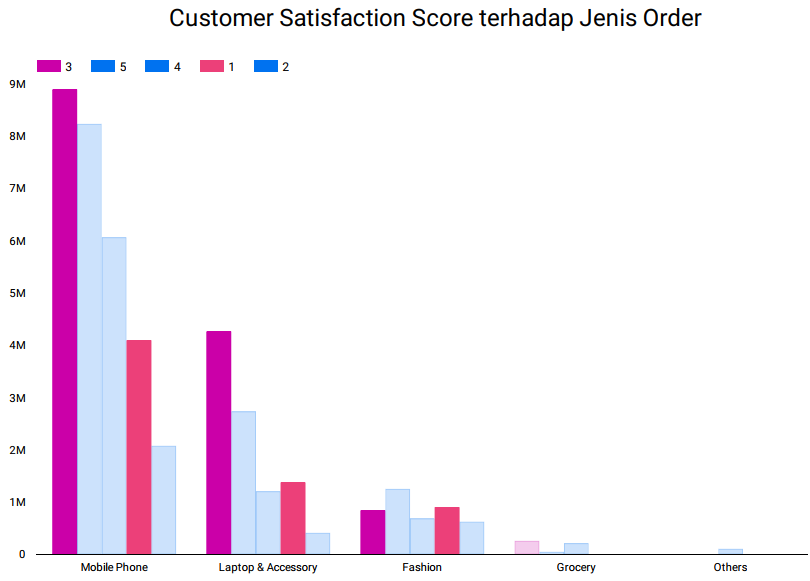

* Mayoritas customer satisfaction score berada di bintang 3, yang artinya customer bersikap netral
* Hanya saja, semua barang elektronik (Mobile Phone, laptop, aksesoris) memiliki bintang 1 yang menduduki peringkat kedua. Hal ini berarti kepuasan customer dalam membeli barang elektronik sangat rendah

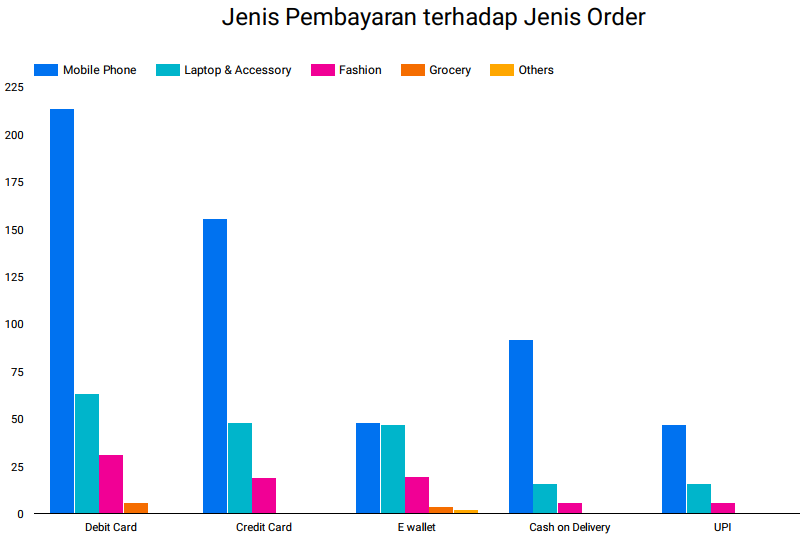

* Terlihat bahwa mayoritas customer yang churn adalah pengguna debit, credit, dan COD
* Churn terendah adalah pengguna e-Wallet
* Pengguna memutuskan churn karena e-Commerce kita mungkin mempersulit mereka untuk mengguna e-Wallet dengan banjirnya promo yang hanya dari debit dan credit. Sementara sekarang adalah era berjayanya dari e-Wallet dengan kekuatan cashback-nya

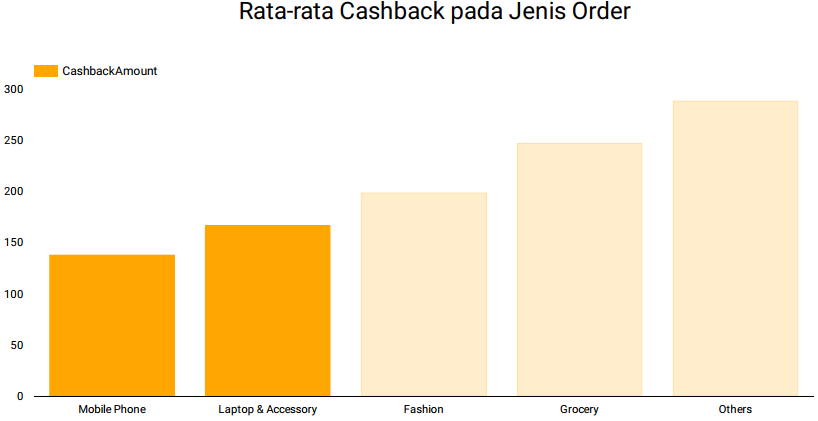

* Ternyata, rata-rata cashback pada barang elektronik sedikit dibanding dengan barang lain
* Hal ini menjadi faktor menurunnya pembelian customer terhadap barang-barang elektronik di e-Commerce ini

# Feature Engineering

In [ ]:
# Load data yang sudah bersih
# LANGSUNG RUNNING SINI AJA YAAA
# Load dataset (sudah saya koneksikan dengan Github, jadi tinggal run aja okay :D )
!git clone https://github.com/yohset95/DatasetFP_FSB

fatal: destination path 'DatasetFP_FSB' already exists and is not an empty directory.


In [ ]:
df = pd.read_csv('/content/DatasetFP_FSB/df.csv') 
df.head()

,CustomerID,Churn,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,5.0,159.93
1,50002,1,Mobile Phone,1,8.0,UPI,Male,3.0,4,Mobile Phone,3,Single,7,1,15.0,1.0,0.0,120.90
2,50003,1,Mobile Phone,1,30.0,Debit Card,Male,2.0,4,Mobile Phone,3,Single,6,1,14.0,1.0,3.0,120.28
3,50004,1,Mobile Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,1.0,3.0,134.07
4,50005,1,Mobile Phone,1,12.0,Credit Card,Male,0.0,3,Mobile Phone,5,Single,3,0,11.0,1.0,3.0,129.60


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4758 entries, 0 to 4757
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   4758 non-null   int64  
 1   Churn                        4758 non-null   int64  
 2   PreferredLoginDevice         4758 non-null   object 
 3   CityTier                     4758 non-null   int64  
 4   WarehouseToHome              4758 non-null   float64
 5   PreferredPaymentMode         4758 non-null   object 
 6   Gender                       4758 non-null   object 
 7   HourSpendOnApp               4758 non-null   float64
 8   NumberOfDeviceRegistered     4758 non-null   int64  
 9   PreferedOrderCat             4758 non-null   object 
 10  SatisfactionScore            4758 non-null   int64  
 11  MaritalStatus                4758 non-null   object 
 12  NumberOfAddress              4758 non-null   int64  
 13  Complain          

## Drop Kolom CustomerID

In [ ]:
df.drop(columns=['CustomerID'], inplace=True)

## Log Transformation

Karena beberapa kolom skewed, yakni: WarehouseToHome, OrderAmountHikeFromlastYear, DaySinceLastOrder, CashbackAmount, maka keempat kolom tersebut dilakukan log transformation agar distribusinya mendekati normal

In [ ]:
skewed = ['WarehouseToHome', 'OrderAmountHikeFromlastYear', 'DaySinceLastOrder', 'CashbackAmount']
for i in skewed:
  logt = np.log(df[i]+1)
  df[i] = logt

print("Log Transformation success!")

Log Transformation success!


## Encoding

In [ ]:
df_encoded=df.copy()
df_encoded.head()

,Churn,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,OrderCount,DaySinceLastOrder,CashbackAmount
0,1,Mobile Phone,3,1.945910,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,2.484907,1.0,1.791759,5.080969
1,1,Mobile Phone,1,2.197225,UPI,Male,3.0,4,Mobile Phone,3,Single,7,1,2.772589,1.0,0.000000,4.803201
2,1,Mobile Phone,1,3.433987,Debit Card,Male,2.0,4,Mobile Phone,3,Single,6,1,2.708050,1.0,1.386294,4.798102
3,1,Mobile Phone,3,2.772589,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,3.178054,1.0,1.386294,4.905793
4,1,Mobile Phone,1,2.564949,Credit Card,Male,0.0,3,Mobile Phone,5,Single,3,0,2.484907,1.0,1.386294,4.872139


In [ ]:
df_encoded = pd.get_dummies(df_encoded,drop_first=True)
df_encoded.head(10)

,Churn,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Mobile Phone,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1,3,1.945910,3.0,3,2,9,1,2.484907,1.0,1.791759,5.080969,1,0,1,0,0,0,0,1,0,0,0,1
1,1,1,2.197225,3.0,4,3,7,1,2.772589,1.0,0.000000,4.803201,1,0,0,0,1,1,0,0,1,0,0,1
2,1,1,3.433987,2.0,4,3,6,1,2.708050,1.0,1.386294,4.798102,1,0,1,0,0,1,0,0,1,0,0,1
3,1,3,2.772589,2.0,4,5,8,0,3.178054,1.0,1.386294,4.905793,1,0,1,0,0,1,0,1,0,0,0,1
4,1,1,2.564949,0.0,3,5,3,0,2.484907,1.0,1.386294,4.872139,1,1,0,0,0,1,0,0,1,0,0,1
5,1,1,3.135494,3.0,5,5,2,1,3.135494,6.0,2.079442,4.942999,0,0,1,0,0,0,0,0,1,0,0,1
6,1,3,2.484907,2.0,3,2,4,0,2.708050,1.0,0.000000,4.802873,1,0,0,0,0,1,0,1,0,0,0,0
7,1,1,1.945910,3.0,3,2,3,1,2.833213,2.0,0.000000,4.819717,1,1,0,0,0,1,0,0,1,0,0,0
8,1,3,2.302585,0.0,4,3,2,1,2.708050,1.0,1.098612,4.850701,1,0,0,1,0,1,0,0,1,0,0,0
9,1,1,3.465736,2.0,5,3,2,0,2.564949,1.0,0.693147,4.819717,1,0,1,0,0,1,0,0,1,0,0,1


## Train-Test Split

* Sebelum proses scaling dan penanganan imbalanced class, train-test split harus dilakukan untuk mencegah data leakage

In [ ]:
# Separate features and target variables
df_features = df_encoded.loc[:, df_encoded.columns != "Churn"]
df_target = df_encoded["Churn"]

In [ ]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.30, random_state=42, stratify=df_target)
print('Class from training data ',Counter(y_train))

Class from training data  Counter({0: 2733, 1: 597})


## Scaling

In [ ]:
scaler = StandardScaler()

In [ ]:
num = ['CityTier', 'WarehouseToHome','HourSpendOnApp',
 'NumberOfDeviceRegistered',
 'SatisfactionScore',
 'NumberOfAddress',
 'Complain',
 'OrderAmountHikeFromlastYear',
 'OrderCount',
 'DaySinceLastOrder',
 'CashbackAmount']
num

['CityTier',
 'WarehouseToHome',
 'HourSpendOnApp',
 'NumberOfDeviceRegistered',
 'SatisfactionScore',
 'NumberOfAddress',
 'Complain',
 'OrderAmountHikeFromlastYear',
 'OrderCount',
 'DaySinceLastOrder',
 'CashbackAmount']

In [ ]:
# Scaling pada data training
features = X_train[num]
features = scaler.fit_transform(features)
X_train_encoded = X_train.copy()
X_train_encoded[num] = features

X_train_encoded

,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Mobile Phone,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
2399,1.465070,-1.085082,-0.764846,-2.532768,-0.052829,-1.225388,-0.629000,-0.398126,-0.660014,0.949000,0.124488,1,1,0,0,0,0,0,1,0,0,0,1
3045,-0.719741,1.947788,0.265468,1.321947,-0.052829,-0.440593,-0.629000,1.859926,0.866621,1.266396,0.280110,0,1,0,0,0,0,0,1,0,0,0,1
2277,-0.719741,-1.085082,0.265468,0.358269,-1.512743,-1.225388,1.589825,-0.398126,-0.660014,0.280474,-0.388450,0,1,0,0,0,1,0,0,1,0,0,1
2084,1.465070,-1.337768,-0.764846,1.321947,-0.052829,-0.832991,-0.629000,-1.085630,-0.660014,-2.008765,-1.788952,0,0,1,0,0,0,0,0,1,0,0,1
4346,1.465070,0.927837,1.295783,0.358269,1.407086,-0.440593,-0.629000,-0.729591,3.919891,0.949000,0.746371,1,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,-0.719741,-0.137195,-0.764846,-0.605410,-1.512743,-0.832991,1.589825,-0.398126,0.866621,1.401964,0.320689,1,1,0,0,0,0,0,0,0,0,0,1
1945,-0.719741,0.010819,-0.764846,0.358269,-1.512743,-0.832991,-0.629000,-0.729591,-0.151135,-0.446116,-1.349960,0,0,0,0,1,1,0,0,1,0,1,0
3820,-0.719741,1.636321,0.265468,0.358269,0.677129,1.913793,-0.629000,0.203198,-0.151135,1.266396,0.620503,0,0,1,0,0,0,0,1,0,0,1,0
2100,-0.719741,-0.467902,-0.764846,-2.532768,-0.052829,-0.440593,1.589825,-1.085630,-0.660014,-0.036922,-1.454041,1,1,0,0,0,1,0,0,1,0,1,0


In [ ]:
# Scaling pada data testing
# tidak perlu di-fit lagi untuk menghindari data leakage
features_test = X_test[num]
features_test = scaler.transform(features_test)
X_test_encoded = X_test.copy()
X_test_encoded [num] = features_test

X_test_encoded

,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice_Mobile Phone,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
3638,-0.719741,-1.337768,0.265468,0.358269,0.677129,-0.440593,-0.629000,0.737563,-0.151135,-1.022843,-0.364120,1,1,0,0,0,1,0,0,1,0,0,1
2188,1.465070,0.927837,-0.764846,-0.605410,0.677129,-0.440593,-0.629000,-1.085630,-0.660014,-0.446116,-0.646217,1,0,1,0,0,0,0,1,0,0,0,1
3407,-0.719741,1.190862,0.265468,2.285626,-1.512743,0.344202,1.589825,0.477806,-0.151135,-1.022843,0.659063,1,1,0,0,0,1,0,1,0,0,1,0
3155,-0.719741,0.010819,1.295783,0.358269,-0.052829,-0.440593,-0.629000,0.983993,-0.151135,-0.446116,0.392052,1,0,1,0,0,1,0,1,0,0,0,0
3549,1.465070,0.149277,0.265468,0.358269,-0.052829,-0.832991,1.589825,1.859926,-0.151135,0.539806,0.399134,1,0,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4071,-0.719741,-0.296183,0.265468,1.321947,-0.052829,-0.440593,1.589825,-0.088062,-0.151135,1.116533,-0.410481,0,1,0,0,0,0,0,0,1,0,1,0
478,-0.719741,0.010819,0.265468,-0.605410,-0.052829,-0.832991,-0.629000,0.983993,-0.660014,-2.008765,-1.374017,1,0,1,0,0,0,0,0,1,0,0,1
3310,-0.719741,1.702337,0.265468,0.358269,1.407086,-0.440593,-0.629000,-0.088062,-0.151135,0.539806,-0.126919,1,0,1,0,0,0,0,0,1,0,1,0
4048,-0.719741,0.279338,0.265468,1.321947,0.677129,-0.440593,-0.629000,-1.085630,-0.151135,-1.022843,-0.298555,0,0,1,0,0,1,0,0,1,0,1,0


## SMOTE

* Dilakukan proses SMOTE pada data training untuk handling severe imbalanced class pada class Churn

In [ ]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(X_train_encoded, y_train)
print('Class from training data X_train_SMOTE',Counter(y_train_SMOTE))

Class from training data X_train_SMOTE Counter({0: 2733, 1: 2733})


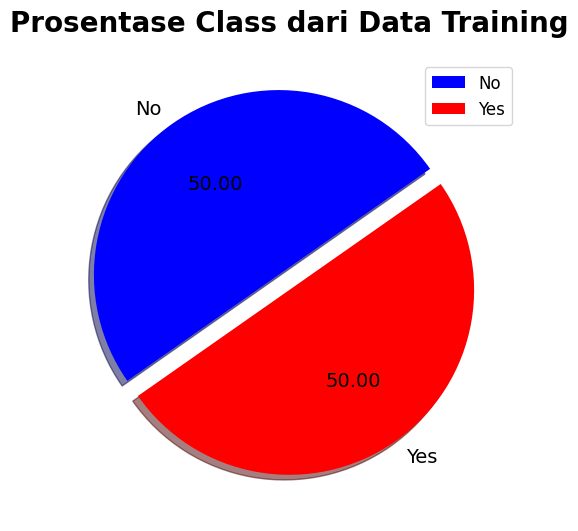

In [ ]:
# Distribusi class data training setelah SMOTE
plt.figure(figsize=(6,6))
plt.pie(
        y_train_SMOTE.value_counts(),
        autopct='%.2f',
        explode=[0.1,0],
        labels=["No","Yes"], 
        shadow=True, 
        textprops={'fontsize': 14},
        colors=["blue","red"], 
        startangle=35)

plt.title("Prosentase Class dari Data Training",fontsize=20, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc="best")
plt.show()

# Modelling

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Logistic Regression

Training is success!
Classification report Logistic Regression Classifier : 
               precision    recall  f1-score   support

           0       0.92      0.82      0.87      1172
           1       0.45      0.69      0.54       256

    accuracy                           0.79      1428
   macro avg       0.69      0.75      0.70      1428
weighted avg       0.84      0.79      0.81      1428



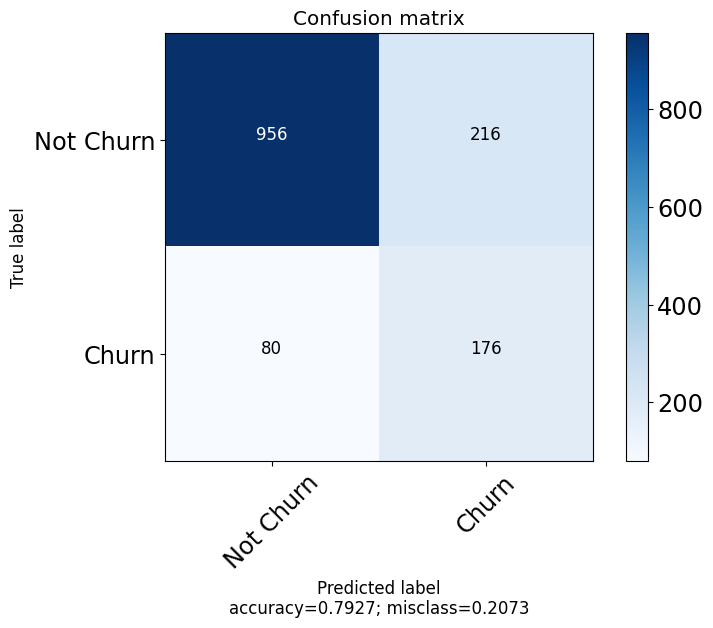

In [ ]:
model_LR = LogisticRegression(random_state=42)
model_LR.fit(X_train_SMOTE, y_train_SMOTE) 
print("Training is success!")
predicted = model_LR.predict(X_test_encoded)
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, predicted)
print('Classification report Logistic Regression Classifier : \n',matrix)
cm = confusion_matrix(y_test, predicted)
target_names = ["Not Churn","Churn"]
plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None,normalize=False)

In [ ]:
y_train_pred = model_LR.predict(X_train_SMOTE)
print("Training Recall:",metrics.recall_score(y_train_SMOTE, y_train_pred))
print("Predict Recall:",metrics.recall_score(y_test, predicted))

Training Recall: 0.8170508598609586
Predict Recall: 0.6875


* Recall training > recall prediction
* Modelnya overfitting

### Feature Importance

In [ ]:
column = list(X_train_SMOTE.columns.values)
column

['CityTier',
 'WarehouseToHome',
 'HourSpendOnApp',
 'NumberOfDeviceRegistered',
 'SatisfactionScore',
 'NumberOfAddress',
 'Complain',
 'OrderAmountHikeFromlastYear',
 'OrderCount',
 'DaySinceLastOrder',
 'CashbackAmount',
 'PreferredLoginDevice_Mobile Phone',
 'PreferredPaymentMode_Credit Card',
 'PreferredPaymentMode_Debit Card',
 'PreferredPaymentMode_E wallet',
 'PreferredPaymentMode_UPI',
 'Gender_Male',
 'PreferedOrderCat_Grocery',
 'PreferedOrderCat_Laptop & Accessory',
 'PreferedOrderCat_Mobile Phone',
 'PreferedOrderCat_Others',
 'MaritalStatus_Married',
 'MaritalStatus_Single']

In [ ]:
importance=model_LR.coef_[0]
importance=np.sort(importance)
importance = list(importance)
importance

[-2.253319318928577,
 -1.9404416093405445,
 -1.922139095994276,
 -1.748367438762526,
 -1.4272013582681509,
 -1.3810309652233073,
 -1.222901421152524,
 -0.9774971514524047,
 -0.9424364585828047,
 -0.7664339328318581,
 -0.5263208754784814,
 -0.4076330463042326,
 -0.09546910499574984,
 -0.02977192848413754,
 0.0447356300938975,
 0.19217267546658012,
 0.2886215240808583,
 0.33692358845133075,
 0.4105293390639612,
 0.41186061292138637,
 0.4495387935325911,
 0.5298037509234116,
 0.7948212644420156]

In [ ]:
LR_importance = pd.DataFrame(list(zip(column, importance)), columns =['Kolom', 'Importance'])
LR_importance

,Kolom,Importance
0,CityTier,-2.253319
1,WarehouseToHome,-1.940442
2,HourSpendOnApp,-1.922139
3,NumberOfDeviceRegistered,-1.748367
4,SatisfactionScore,-1.427201
5,NumberOfAddress,-1.381031
6,Complain,-1.222901
7,OrderAmountHikeFromlastYear,-0.977497
8,OrderCount,-0.942436
9,DaySinceLastOrder,-0.766434


In [ ]:
LR_importance.nlargest(10,'Importance')

,Kolom,Importance
22,MaritalStatus_Single,0.794821
21,MaritalStatus_Married,0.529804
20,PreferedOrderCat_Others,0.449539
19,PreferedOrderCat_Mobile Phone,0.411861
18,PreferedOrderCat_Laptop & Accessory,0.410529
17,PreferedOrderCat_Grocery,0.336924
16,Gender_Male,0.288622
15,PreferredPaymentMode_UPI,0.192173
14,PreferredPaymentMode_E wallet,0.044736
13,PreferredPaymentMode_Debit Card,-0.029772


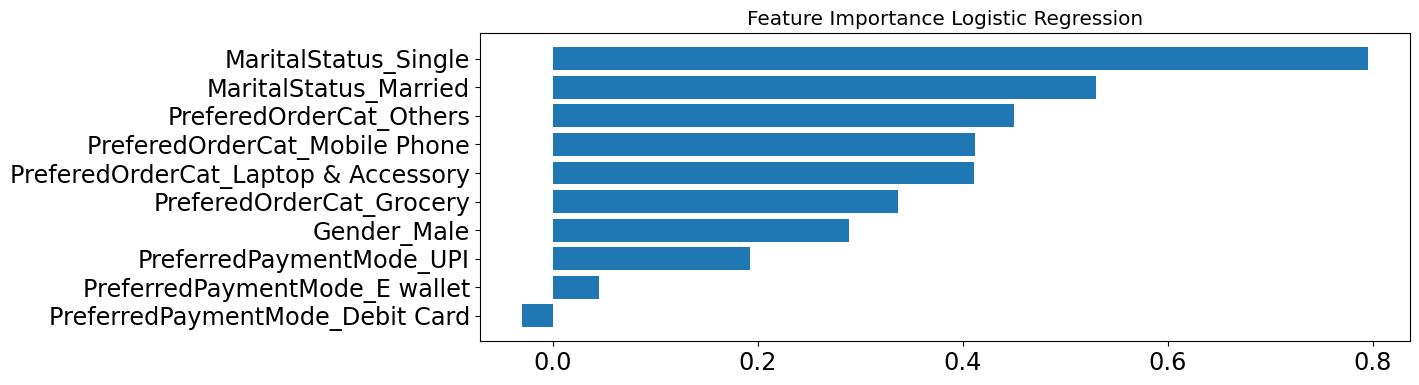

In [ ]:
plt.barh(LR_importance.nlargest(10,'Importance')['Kolom'][::-1],LR_importance.nlargest(10,'Importance')['Importance'][::-1])
plt.title('Feature Importance Logistic Regression')
plt.show()

* Karena dari top 10 feature importance terdapat nilai negatif, maka dipilih top 5 fitur saja

Top 5 fitur terpilih:
* MaritalStatus_Single
* MaritalStatus_Married
* PreferedOrderCat_Others
* PreferedOrderCat_Mobile Phone
* PreferedOrderCat_Laptop & Accessory

Dari top 5 fitur diatas, akan dilakukan hyperparameter tuning untuk mencari model dengan recall terbaik

In [ ]:
train_LR = X_train_SMOTE[['MaritalStatus_Single','MaritalStatus_Married','PreferedOrderCat_Others','PreferedOrderCat_Mobile Phone','PreferedOrderCat_Laptop & Accessory']]
test_LR = X_test_encoded[['MaritalStatus_Single','MaritalStatus_Married','PreferedOrderCat_Others','PreferedOrderCat_Mobile Phone','PreferedOrderCat_Laptop & Accessory']]
print('Success')

Success


### Hyperparameter Tuning

Best Penalty: l1
Best C: 0.0001
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1172
           1       0.00      0.00      0.00       256

    accuracy                           0.82      1428
   macro avg       0.41      0.50      0.45      1428
weighted avg       0.67      0.82      0.74      1428



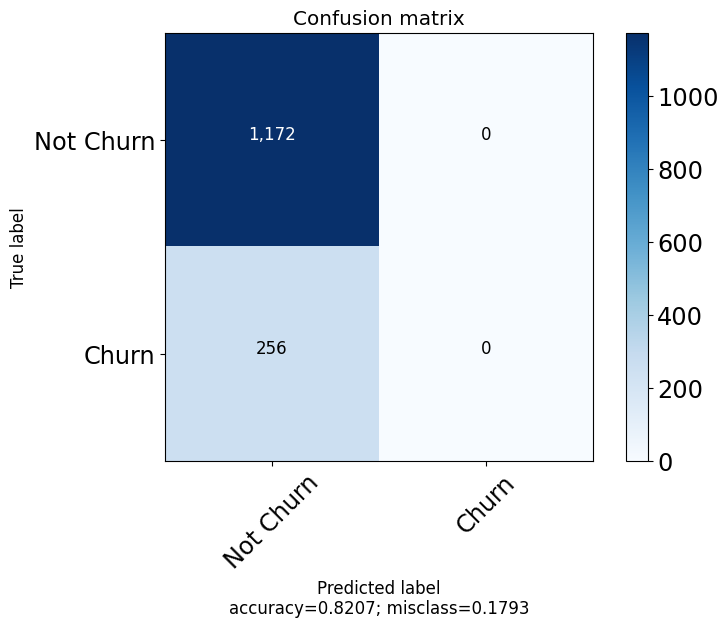

In [ ]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]
clf = GridSearchCV(estimator = LogisticRegression(random_state=42), scoring='recall', param_grid = param_grid, cv=10)
best_model = clf.fit(train_LR,y_train_SMOTE)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
y_pred = best_model.predict(test_LR)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
target_names = ["Not Churn","Churn"]
plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None,normalize=False)

## k-Nearest Neighbor

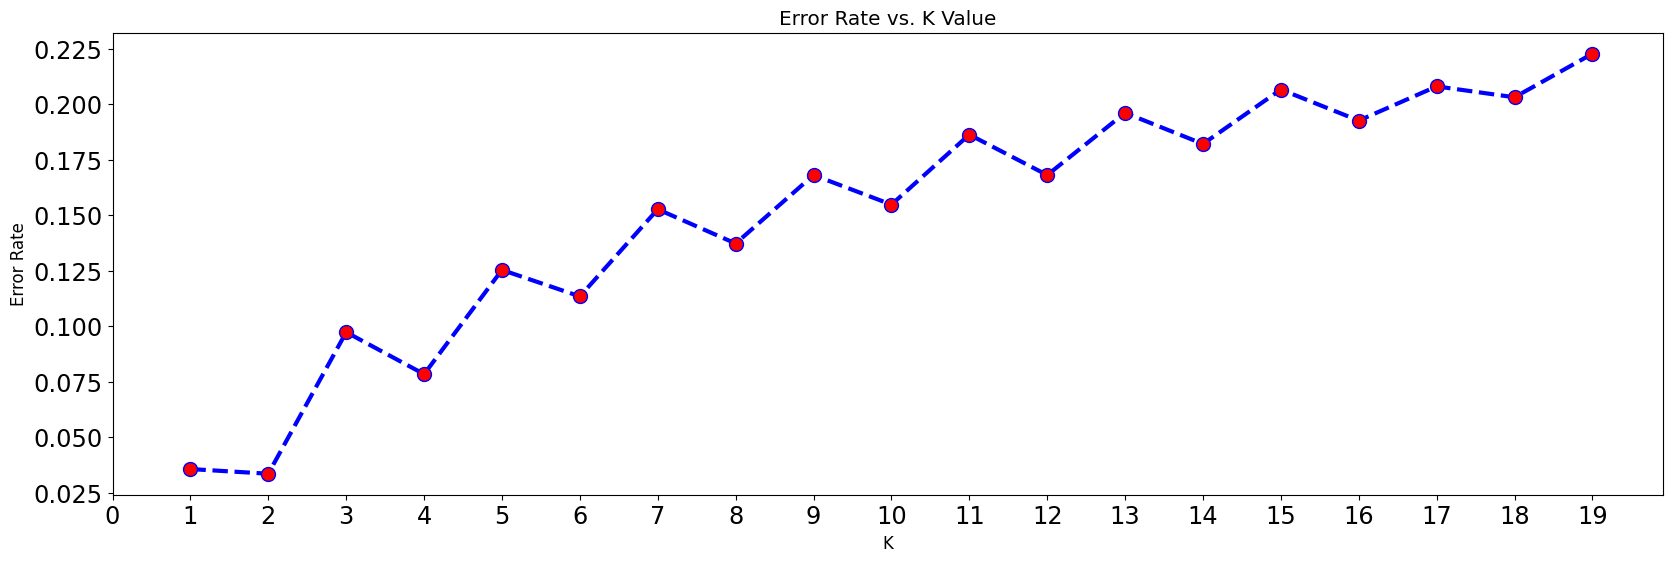

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#Mencari nilai k yang paling optimal dengan metode elbow
error_rate = []

for i in range(1,20):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train_SMOTE,y_train_SMOTE)
  prediksi = knn.predict(X_test_encoded)
  error_rate.append(np.mean(prediksi != y_test))

plt.figure(figsize=(20,6))
plt.plot(range(1,20), error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.xticks(np.arange(0, 20, 1))
plt.ylabel('Error Rate')
plt.show()

Dari grafik diatas, pada dasarnya nilai 'k' yang paling optimal diperoleh ketika nilai 'k' genap. Namun untuk menghindari undefined prediction (karena disini hanya ada 2 kemungkinan, yaitu 1 dan 0) maka dipilih nilai k=3.

Training is success!
Classification report KNN Classifier : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      1172
           1       0.66      0.95      0.78       256

    accuracy                           0.90      1428
   macro avg       0.82      0.92      0.86      1428
weighted avg       0.93      0.90      0.91      1428



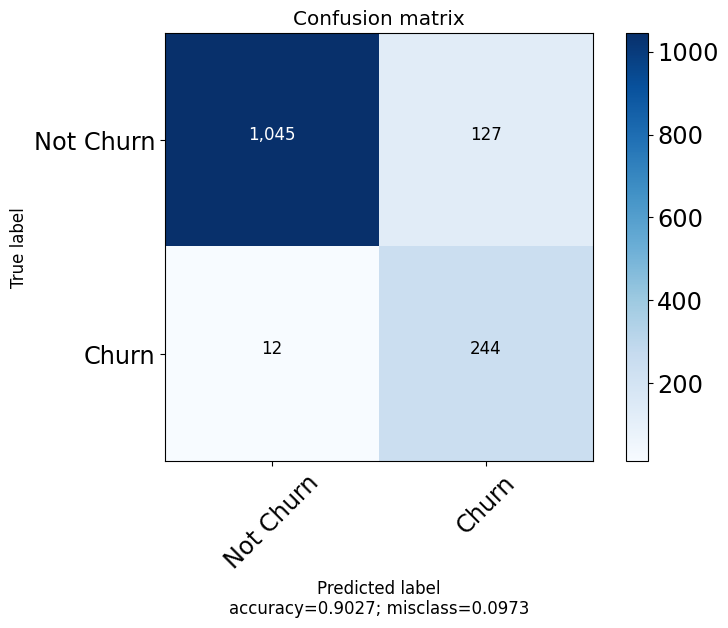

In [ ]:
model_KNN = KNeighborsClassifier(n_neighbors=3)
model_KNN.fit(X_train_SMOTE, y_train_SMOTE) 
print("Training is success!")
predicted = model_KNN.predict(X_test_encoded)


# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, predicted)
print('Classification report KNN Classifier : \n',matrix)
cm = confusion_matrix(y_test, predicted)
target_names = ["Not Churn","Churn"]
plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None,normalize=False)

In [ ]:
y_train_pred = model_KNN.predict(X_train_SMOTE)
print("Training Recall:",metrics.recall_score(y_train_SMOTE, y_train_pred))
print("Predict Recall:",metrics.recall_score(y_test, predicted))

Training Recall: 1.0
Predict Recall: 0.953125


Dari hasil diatas, perbedaan skor recall antara data training dengan data test sekitar 5%.

### Hyperparameter Tuning

Best n_neighbors: 3
Best weights: distance
Best metric: minkowski
Best p: 1

Classification report KNN Classifier : 
               precision    recall  f1-score   support

           0       0.98      0.95      0.97      1172
           1       0.81      0.93      0.86       256

    accuracy                           0.95      1428
   macro avg       0.90      0.94      0.92      1428
weighted avg       0.95      0.95      0.95      1428



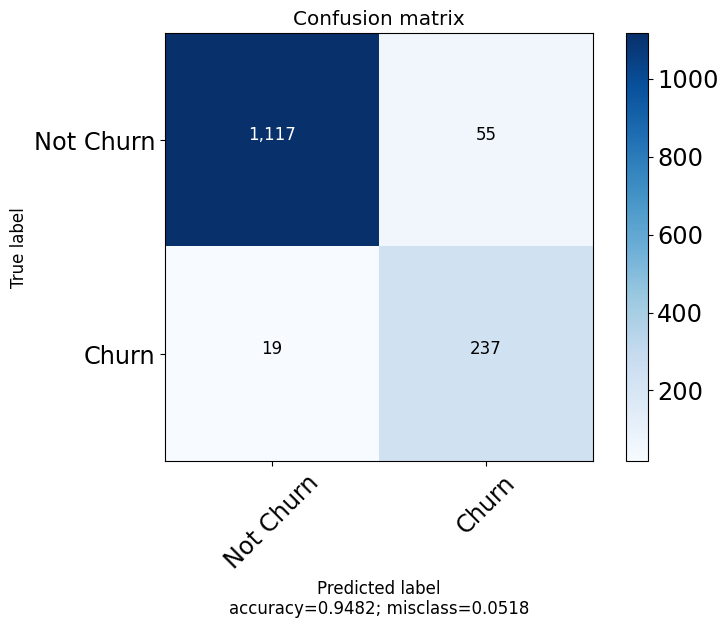

In [ ]:
#List Hyperparameters that we want to tune.
n_neighbors = [3,5,7,9,11] #default = 5
weights = ['uniform','distance'] #default = 'uniform'
metric = ['minkowski','euclidean','manhattan'] #default = 'minkowski'
p=[1,2] #default = 2

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors,
                       weights=weights,
                       metric=metric,
                       p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()

#Use GridSearch
clf = GridSearchCV(estimator = knn_2, scoring='recall', param_grid = hyperparameters, cv=10)

#Fit the model
best_model_KNN = clf.fit(X_train_SMOTE, y_train_SMOTE)

#Print The value of best Hyperparameters
print('Best n_neighbors:', best_model_KNN.best_estimator_.get_params()['n_neighbors'])
print('Best weights:', best_model_KNN.best_estimator_.get_params()['weights'])
print('Best metric:', best_model_KNN.best_estimator_.get_params()['metric'])
print('Best p:', best_model_KNN.best_estimator_.get_params()['p'])
print()

y_pred = best_model_KNN.predict(X_test_encoded)
matrix = classification_report(y_test, y_pred)
print('Classification report KNN Classifier : \n',matrix)
cm = confusion_matrix(y_test, y_pred)
target_names = ["Not Churn","Churn"]
plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None,normalize=False)

In [ ]:
y_train_pred = best_model_KNN.predict(X_train_SMOTE)
print("Training Recall:",metrics.recall_score(y_train_SMOTE, y_train_pred))
print("Predict Recall:",metrics.recall_score(y_test, y_pred))

Training Recall: 1.0
Predict Recall: 0.92578125


### Thresholds

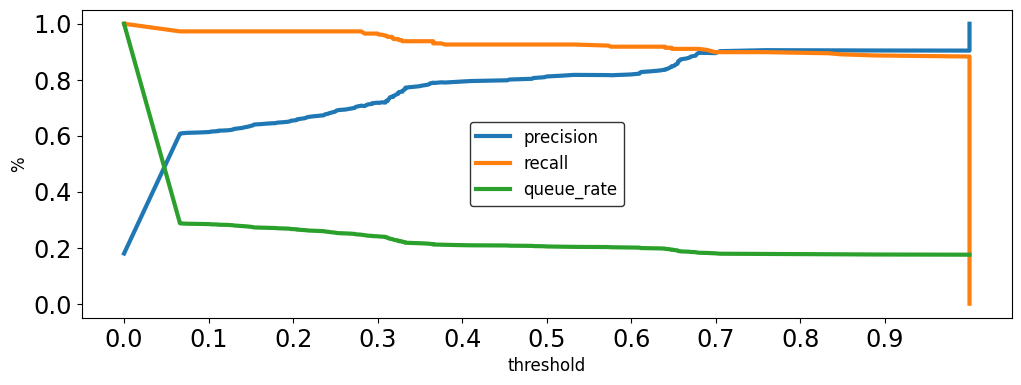

In [ ]:
from sklearn.metrics import precision_recall_curve 

test_labels = y_test
predictions = best_model_KNN.predict_proba(X_test_encoded)[:,1]

precision, recall, thresholds = precision_recall_curve(test_labels, predictions) 
thresholds = np.append(thresholds, 1) 
queue_rate = [] 

for threshold in thresholds: 
    queue_rate.append((predictions >= threshold).mean()) 

plot_precision = plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
plot_recall = plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
plot_queue_rate = plt.plot(thresholds, queue_rate, color=sns.color_palette()[2]) 
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold') 
plt.ylabel('%')
plt.xticks(np.arange(0, 1, step=0.1))
plt.show()

In [ ]:
log_akun = 1000
que_val = 200
print(f'Banyak customer yang diprediksi churn: {log_akun}\nBanyak customer yang dapat di handle: {que_val}\n')

xvalues = [round(i,4) for i in list(plot_recall[0].get_xdata())]
yrecall = list(plot_recall[0].get_ydata())
yprecision = list(plot_precision[0].get_ydata())
yqueue_rate = list(plot_queue_rate[0].get_ydata())

plot_val = [xvalues, yqueue_rate, yprecision, yrecall]
all_values = {'threshold' : [],
              'queue_rate' : [],
              'precision' : [],
              'recall' : []}

for i in range(len(xvalues)):
  que = round(yqueue_rate[i]*log_akun)
  thr = round(xvalues[i],4)
  if que <= que_val and (thr < 1 and thr > 0)==True:
    for name,val in zip(all_values,plot_val):
      all_values[name].append(val[i])

scheme = len(all_values["threshold"])
print(f'Total Scheme : {scheme}\n')

if scheme > 0:
  max_rec = max(all_values['recall'])
  max_index = [all_values['recall'].index(max_rec)]

  for i in max_index:
    thr = round(all_values["threshold"][i],2)
    que = round(all_values["queue_rate"][i]*log_akun)
    pre = round(all_values["precision"][i]*100,2)
    rec = round(all_values["recall"][i]*100,2)
    print('skema:',i+1)
    print(f'threshold : {thr}')
    print(f'queue rate : {que}')
    print(f'precision : {pre}%')
    print(f'recall : {rec}%')
    print('\n')

  print('Pembahasan:')
  print(f'Misal kita menggunakan threshold = {thr}. Dari {log_akun} customer yang dinilai untuk churn per harinya,')
  print(f'sekitar {que} customer akan dipilih untuk mendapatkan promo. Jika tidak diberi promo,')
  print(f'ada kemungkinan {pre}% dari {que} customer tersebut akan churn berdasarkan model yang kita buat.')
  print(f'Dari semua pengguna yang akan churn di periode waktu berikutnya, sekitar {rec}%-nya akan ditangkap \noleh model kami.')

Banyak customer yang diprediksi churn: 1000
Banyak customer yang dapat di handle: 200

Total Scheme : 32

skema: 1
threshold : 0.61
queue rate : 200
precision : 82.17%
recall : 91.8%


Pembahasan:
Misal kita menggunakan threshold = 0.61. Dari 1000 customer yang dinilai untuk churn per harinya,
sekitar 200 customer akan dipilih untuk mendapatkan promo. Jika tidak diberi promo,
ada kemungkinan 82.17% dari 200 customer tersebut akan churn berdasarkan model yang kita buat.
Dari semua pengguna yang akan churn di periode waktu berikutnya, sekitar 91.8%-nya akan ditangkap 
oleh model kami.


###Feature Importance

In [ ]:
kolom = list(X_train_SMOTE.columns.copy())
importance = []

for i in kolom:
  skors =[]
  for j in range(50):
    valid = X_test_encoded.copy()
    valid[i] = np.random.permutation(valid[i])
    pred = best_model_KNN.predict(valid) 
    skor = metrics.recall_score(y_test, pred)
    skors.append(y_pred - skor)
  
  if np.max(skors) <= 0:
    kolom.remove(i)
  
  else:
    importance.append(np.max(skors))

KNN_importance = pd.DataFrame(list(zip(kolom, importance)), columns =['Kolom', 'Importance'])
KNN_importance = KNN_importance.sort_values(by=['Importance'], ascending = False, ignore_index = True)

nmaks = np.max(KNN_importance['Importance'])
KNN_importance['Range 100'] = round(KNN_importance['Importance']*100/nmaks,2)
KNN_importance

,Kolom,Importance,Range 100
0,Complain,0.171875,100.00
1,OrderAmountHikeFromlastYear,0.152344,88.64
2,CityTier,0.140625,81.82
3,NumberOfAddress,0.140625,81.82
4,WarehouseToHome,0.132812,77.27
5,DaySinceLastOrder,0.132812,77.27
6,SatisfactionScore,0.128906,75.00
7,OrderCount,0.109375,63.64
8,PreferedOrderCat_Mobile Phone,0.105469,61.36
9,NumberOfDeviceRegistered,0.105469,61.36


Dari dataframe diatas, terlihat bahwa Complain memiliki kontribusi yang paling besar untuk model dibanding feature/variabel lainnya

## Random Forest

Training is success!
Classification report Random Forest Classifier : 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1172
           1       0.88      0.83      0.85       256

    accuracy                           0.95      1428
   macro avg       0.92      0.90      0.91      1428
weighted avg       0.95      0.95      0.95      1428



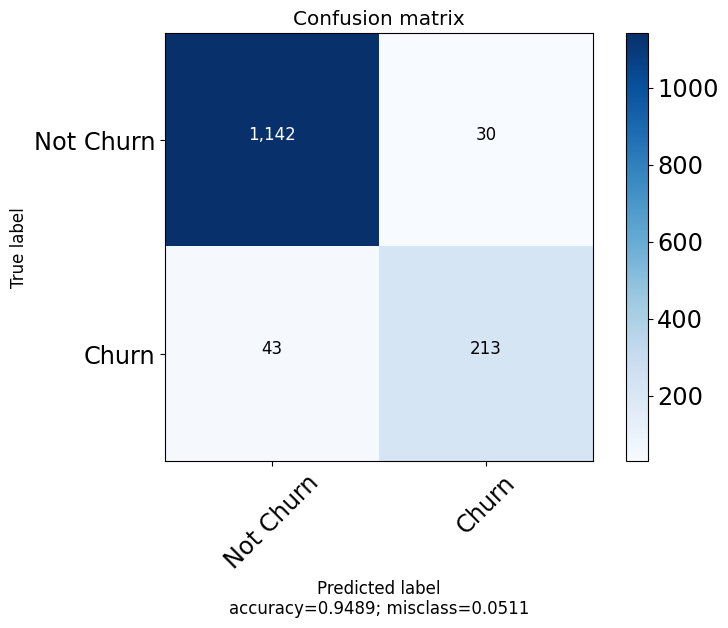

In [ ]:
model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train_SMOTE, y_train_SMOTE) 
print("Training is success!")
predicted = model_RF.predict(X_test_encoded)
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, predicted)
print('Classification report Random Forest Classifier : \n',matrix)
cm = confusion_matrix(y_test, predicted)
target_names = ["Not Churn","Churn"]
plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None,normalize=False)

In [ ]:
y_train_pred = model_RF.predict(X_train_SMOTE)
print("Training Recall:",metrics.recall_score(y_train_SMOTE, y_train_pred))
print("Predict Recall:",metrics.recall_score(y_test, predicted))

Training Recall: 1.0
Predict Recall: 0.83203125


* Recall training > recall prediction
* Modelnya overfitting

### Feature Importance

In [ ]:
feature_scores = pd.Series(model_RF.feature_importances_, index=X_train_SMOTE.columns).sort_values(ascending=False)
feature_scores = feature_scores.reset_index().rename(columns={'index':'Feature',0:'Importance'})
RF_importance = feature_scores.nlargest(10,'Importance')

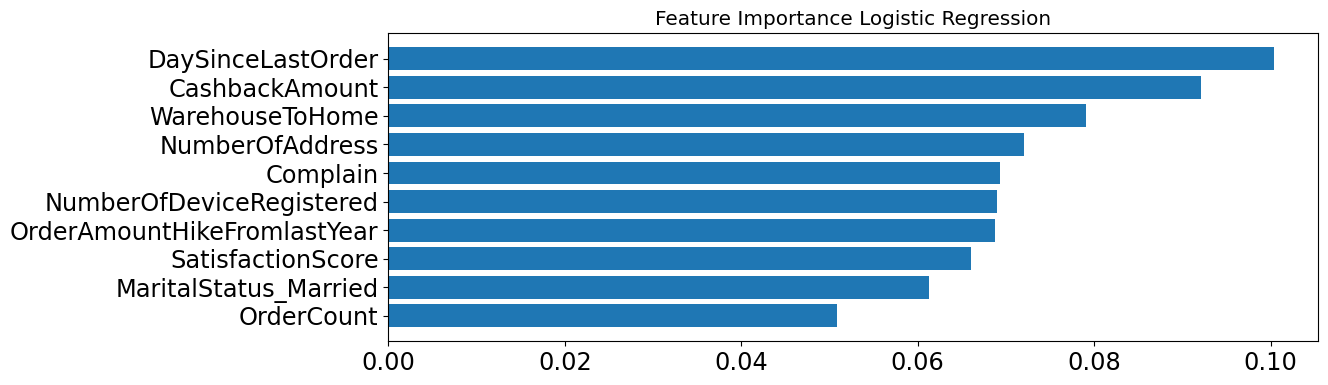

In [ ]:
plt.barh(RF_importance['Feature'][::-1],RF_importance['Importance'][::-1])
plt.title('Feature Importance Logistic Regression')
plt.show()

Dipilih top 5 feature importances:
* DaySinceLastOrder
* CashbackAmount
* WarehouseToHome
* SatisfactionScore
* NumberOfAddress

### Hyperparameter Tuning

In [ ]:
train_RF = X_train_SMOTE[['DaySinceLastOrder','CashbackAmount','WarehouseToHome','SatisfactionScore','NumberOfAddress']]
test_RF = X_test_encoded[['DaySinceLastOrder','CashbackAmount','WarehouseToHome','SatisfactionScore','NumberOfAddress']]
print('Success')

Success


Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1172
           1       0.77      0.75      0.76       256

    accuracy                           0.92      1428
   macro avg       0.86      0.85      0.85      1428
weighted avg       0.91      0.92      0.91      1428



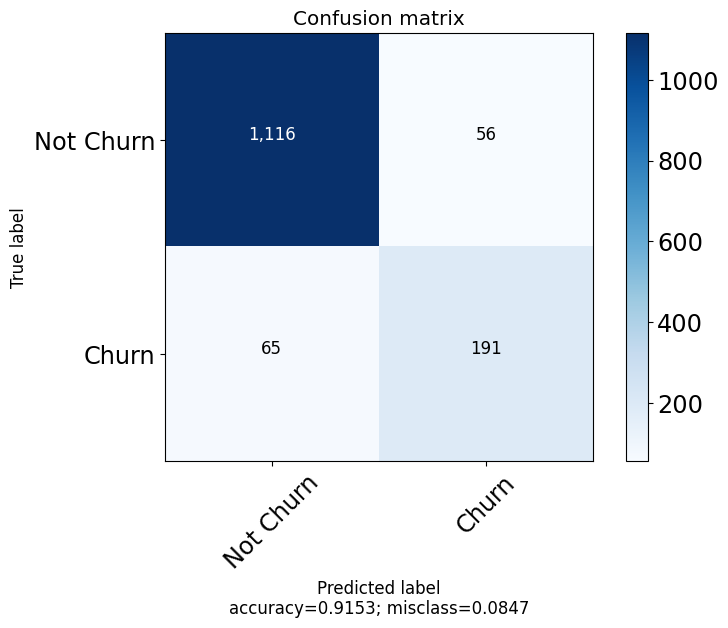

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(train_RF, y_train_SMOTE)
print(rf_random.best_params_)
y_pred = rf_random.predict(test_RF)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
target_names = ["Not Churn","Churn"]
plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None,normalize=False) 

## XGBoost Classifier

Training is success!
Classification report Logistic Regression Classifier : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1172
           1       0.92      0.89      0.90       256

    accuracy                           0.97      1428
   macro avg       0.95      0.94      0.94      1428
weighted avg       0.97      0.97      0.97      1428



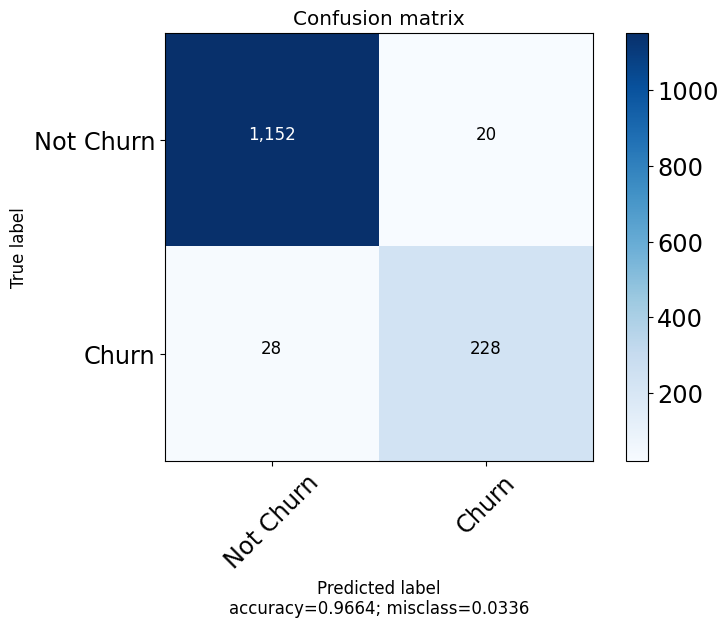

In [ ]:
model_XGB = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model_XGB.fit(X_train_SMOTE, y_train_SMOTE) 
print("Training is success!")
predicted = model_XGB.predict(X_test_encoded)


# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, predicted)
print('Classification report Logistic Regression Classifier : \n',matrix)
cm = confusion_matrix(y_test, predicted)
target_names = ["Not Churn","Churn"]
plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None,normalize=False)

In [ ]:
y_train_pred = model_XGB.predict(X_train_SMOTE)
print("Training Recall:",metrics.recall_score(y_train_SMOTE, y_train_pred))
print("Predict Recall:",metrics.recall_score(y_test, predicted))

Training Recall: 1.0
Predict Recall: 0.890625


* Selisih = 0.12 
* Modelnya overfitting

### Feature Importance

In [ ]:
feature_important = model_XGB.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"])
data = data.reset_index().rename(columns={'index':'Feature', 'score':'Importance'})
data

,Feature,Importance
0,CityTier,2.205479
1,WarehouseToHome,1.223586
2,HourSpendOnApp,2.121500
3,NumberOfDeviceRegistered,4.424716
4,SatisfactionScore,2.181457
5,NumberOfAddress,1.662076
6,Complain,4.683511
7,OrderAmountHikeFromlastYear,1.115632
8,OrderCount,1.855115
9,DaySinceLastOrder,2.697314


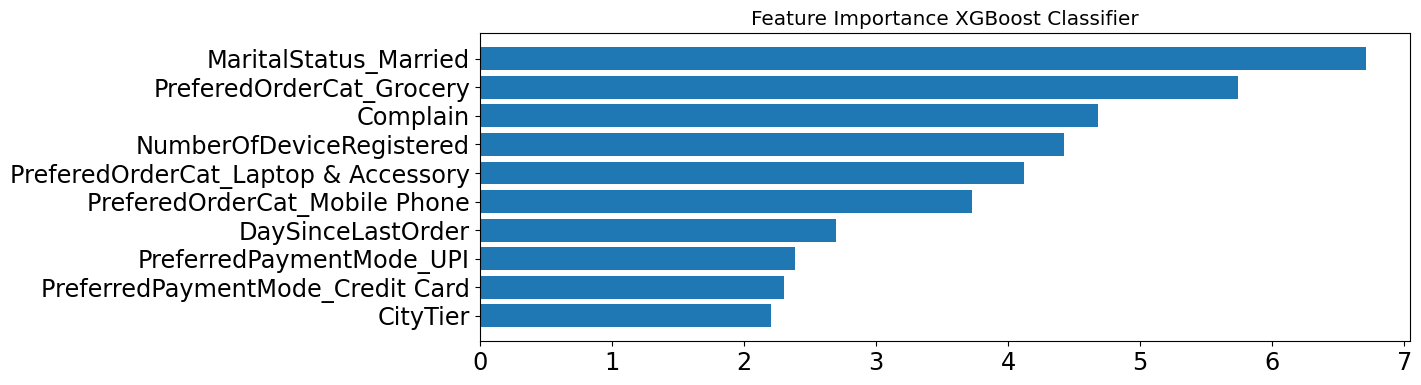

In [ ]:
XGB_importance = data.nlargest(10,'Importance')
plt.barh(XGB_importance['Feature'][::-1],XGB_importance['Importance'][::-1])
plt.title('Feature Importance XGBoost Classifier')
plt.show()

### Hyperparameter Tuning

In [ ]:
search_spaces = {
 'max_depth':[6,8,10],
 'min_child_weight':[1,4,8],
 'learning_rate': [0.01, 0.05, 0.1],
 'n_estimators': [100, 500, 1000],
 'gamma':[i/10.0 for i in range(0,5)],
 'colsample_bytree': [0.3, 0.7],
 'subsample': [0.3, 0.7]
}
clf = BayesSearchCV(estimator = XGBClassifier(random_state=42), scoring='recall', search_spaces=search_spaces, cv=10)
clf.fit(X_train_SMOTE, y_train_SMOTE)

# clf.cv_results_, clf.best_params_, clf.best_score_

BayesSearchCV(cv=10,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=Non...
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=42, ...),
              scoring='recall',
              search_spaces={'colsample_bytree': [0.3, 0.7],
                             'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                             'learning_rate': [0.01, 0.05, 0.1],
                             'max_depth': [6, 8, 10],
                             'min_child_weight': [1, 4, 8],
                             'n_estimators': [100, 500, 1000],
                             'subsample': [0.3, 0.7]})

In [ ]:
print("Best parameter:", clf.best_params_)
print("Best score:", clf.best_score_)

Best parameter: OrderedDict([('colsample_bytree', 0.7), ('gamma', 0.0), ('learning_rate', 0.1), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 500), ('subsample', 0.7)])
Best score: 0.9564102564102563


Dipilih top 5 feature importances:
* MaritalStatus_Married
* PreferedOrderCat_Laptop & Accesory
* Complain
* NumberOfDeviceRegistered
* PreferedOrderCat_Mobile Phone

### Tuning Regularization Parameters

Training is success!
Classification report Logistic Regression Classifier : 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1172
           1       0.93      0.88      0.91       256

    accuracy                           0.97      1428
   macro avg       0.95      0.93      0.94      1428
weighted avg       0.97      0.97      0.97      1428



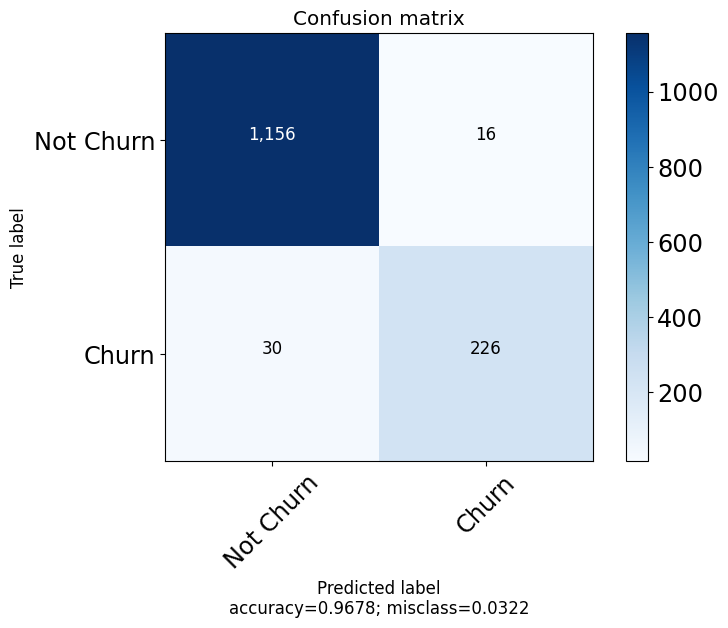

In [ ]:
model_XGB = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.7)

model_XGB.fit(X_train_SMOTE, y_train_SMOTE) 
print("Training is success!")
predicted = model_XGB.predict(X_test_encoded)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, predicted)
print('Classification report Logistic Regression Classifier : \n',matrix)
cm = confusion_matrix(y_test, predicted)
target_names = ["Not Churn","Churn"]
plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None,normalize=False)

# Rekomendasi

* Melakukan analisis komplain pelanggan (apabila ada, yang artinya pelanggan melakukan review produk) sehingga bisa diketahui secara pasti mengenai penyebab barang elektronik mendapat komplain terburuk dibandingkan dengan produk lainnya
* Pelanggan yang churn merupakan pelanggan setia yang tidak memberikan tanda-tanda hendak churn. Sehingga, pemberian promo atau cashback secara berkala perlu diberikan pada customer yang memberikan rating buruk pada produk tertentu
* Menggencarkan penggunaan e-Wallet sebagai sistem pembayaran utama produk melalui bundling promo agar customer tertarik untuk melakukan transaksi di toko kita
* Model ML yang terpilih untuk memprediksi customer churn adalah model KNN, dengan recall sebesar 95% dan tidak overfitting
* Nantinya, apabila model mendeteksi seorang customer akan churn, maka komplain dari customer tersebut harus diprioritaskan untuk diselesaikan terlebih dahulu 